# Differential abundance analysis

In [1]:
figDir = '~/Hyphosphere/data/3Exp/figures'

work_dir = '~/Hyphosphere/data/3Exp'

# phyloseq - full object without tree (includes archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_experimental_woContam.rds'

In [41]:
library(RColorBrewer)
library(vegan)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(DESeq2)
library(emmeans)

ERROR: Error in library(emmeans): there is no package called ‘emmeans’


In [3]:
theme_pub = function (base_size = 8, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            axis.text = element_text(size = base_size),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE,
            legend.text = element_text(size = base_size),
            legend.title = element_text(face = "bold"))
    
    }

In [4]:
ps = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove spore sample
    subset_samples(., SampleType != "GV") %>%
     # re-normalize after subsetting taxa
    transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 18876 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 18876 taxa by 6 taxonomic ranks ]

# Merge at Phylum, Class, Order and Family Levels

In [5]:
rank_names(ps)

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"

In [6]:
ps.phylum = tax_glom(ps, taxrank=rank_names(ps)[2], NArm=FALSE, bad_empty=NA)

In [7]:
ps.phylum

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 39 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 39 taxa by 6 taxonomic ranks ]

In [8]:
ps.class = tax_glom(ps, taxrank=rank_names(ps)[3], NArm=FALSE, bad_empty=NA)
ps.order = tax_glom(ps, taxrank=rank_names(ps)[4], NArm=FALSE, bad_empty=NA)
ps.family = tax_glom(ps, taxrank=rank_names(ps)[5], NArm=FALSE, bad_empty=NA)
ps.class
ps.order
ps.family

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 118 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 118 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 292 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 292 taxa by 6 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 471 taxa and 384 samples ]
sample_data() Sample Data:       [ 384 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 471 taxa by 6 taxonomic ranks ]

# Phylum summary

In [9]:
top10 = names(sort(taxa_sums(ps.phylum), decreasing = TRUE)[1:10])
tmp = prune_taxa(top10, ps.phylum)

Means = tmp %>%
    psmelt %>%
    filter(Experiment %in% c(1,2) & SampleType %in% c("CH", "CS") & Fungus == "Gv") %>%
    group_by(SampleType, Phylum) %>%
    summarize(mAbundance = mean(Abundance),
             sdAbundance = sd(Abundance)) %>%
    dcast(Phylum~SampleType, value.var = c("mAbundance"))
names(Means) = c("Phylum", "mean_CH", "mean_CS")
SDs = tmp %>%
    psmelt %>%
    filter(Experiment %in% c(1,2) & SampleType %in% c("CH", "CS") & Fungus == "Gv") %>%
    group_by(SampleType, Phylum) %>%
    summarize(mAbundance = mean(Abundance),
             sdAbundance = sd(Abundance)) %>%
    dcast(Phylum~SampleType, value.var = c("sdAbundance"))
names(SDs) = c("Phylum", "sd_CH", "sd_CS")

full_join(Means, SDs) %>% arrange(desc(mean_CH))

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'SampleType' (override with `.groups` argument)
Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'SampleType' (override with `.groups` argument)
Joining, by = "Phylum"


Phylum,mean_CH,mean_CS,sd_CH,sd_CS
Proteobacteria,0.50001603,0.31759103,0.106525066,0.101565304
Actinobacteria,0.09546609,0.17939422,0.051293903,0.056153246
Chloroflexi,0.08887441,0.07872786,0.056714813,0.033307369
Acidobacteria,0.06903047,0.11926304,0.019817764,0.037249652
Bacteroidetes,0.05705538,0.04990809,0.035181208,0.054959218
Fibrobacteres,0.04228043,0.00319836,0.044831886,0.003726407
Planctomycetes,0.03858404,0.05911395,0.014780607,0.017329580
Verrucomicrobia,0.03158401,0.04737271,0.018233684,0.013918342
Thaumarchaeota,0.01442145,0.03770709,0.008909914,0.027900420
Gemmatimonadetes,0.01212138,0.03932401,0.006056358,0.020714925


## Phylum Graph

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'SampleType', 'Experiment', 'Soil' (override with `.groups` argument)


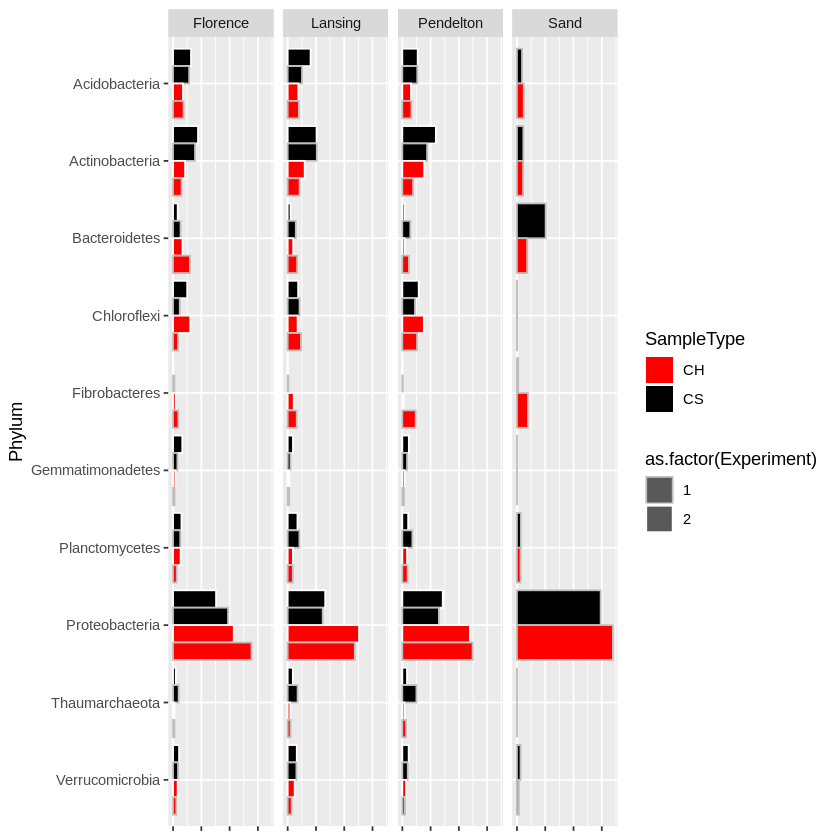

In [10]:
## Transform to relative abundance
#ps.phylum = transform_sample_counts(ps.phylum, function(x) x / sum(x) )
top10 = names(sort(taxa_sums(ps.phylum), decreasing = TRUE)[1:10])
tmp = prune_taxa(top10, ps.phylum)

tmp %>%
    psmelt %>%
    filter(Experiment %in% c(1,2) & SampleType %in% c("CH", "CS") & Fungus == "Gv") %>%
    group_by(SampleType, Experiment, Soil, Phylum) %>%
    summarize(mAbundance = mean(Abundance),
             sdAbundance = sd(Abundance)) %>%
    mutate(Phylum = factor(Phylum, levels = rev(levels(Phylum)))) %>%
   # ggplot code, to group bars by experiment rather than sample type, switch position of fill and colour in aes
    ggplot(., aes(x = Phylum, y = mAbundance, fill = SampleType, colour = as.factor(Experiment)))+
            geom_bar(stat = 'identity', position = position_dodge())+
            theme(axis.text.x = element_blank(), legend.position = 'right', axis.title.x = element_blank())+
            ylab("Relative abundance")+
            scale_x_discrete(limits = rev(levels("Test")))+
            coord_flip() +
            scale_fill_manual(values = c("Red", "Black"))+
            scale_color_manual(values = c('Grey','White'))+
            facet_wrap(~Soil, ncol = 4)
            
    #aes(x = reorder(the_factor, desc(the_factor)), ...)



## Class graph

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'SampleType', 'Experiment', 'Soil' (override with `.groups` argument)


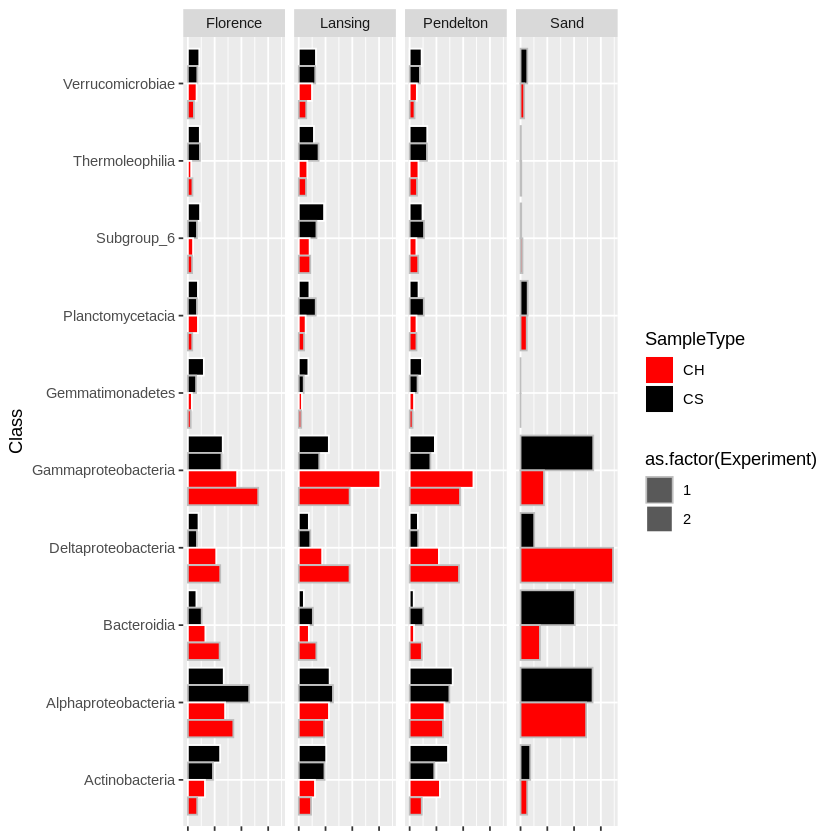

In [11]:
## Transform to relative abundance
#ps.phylum = transform_sample_counts(ps.phylum, function(x) x / sum(x) )
top10 = names(sort(taxa_sums(ps.class), decreasing = TRUE)[1:10])
tmp = prune_taxa(top10, ps.class)

tmp %>%
    psmelt %>%
    filter(Experiment %in% c(1,2) & SampleType %in% c("CH", "CS") & Fungus == "Gv") %>%
    group_by(SampleType, Experiment, Soil, Class) %>%
    summarize(mAbundance = mean(Abundance),
             sdAbundance = sd(Abundance)) %>%
    mutate(Phylum = factor(Class, levels = rev(levels(Class)))) %>%
   # ggplot code, to group bars by experiment rather than sample type, switch position of fill and colour in aes
    ggplot(., aes(x = Class, y = mAbundance, fill = SampleType, colour = as.factor(Experiment)))+
            geom_bar(stat = 'identity', position = position_dodge())+
            theme(axis.text.x = element_blank(), legend.position = 'right', axis.title.x = element_blank())+
            ylab("Relative abundance")+
            scale_x_discrete(limits = rev(levels("Test")))+
            coord_flip() +
            scale_fill_manual(values = c("Red", "Black"))+
            scale_color_manual(values = c('Grey','White'))+
            facet_wrap(~Soil, ncol = 4)
            

## Order graph

## Statistical test for order abundance

* design (abundance ~ soil*experiment*Sample type + sampletype:experiment)
* contrasts = exp1 CH vs CS, exp2 CH vs CS | soil
* combine contrasts and adjust p values

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

[1] "Betaproteobacteriales"


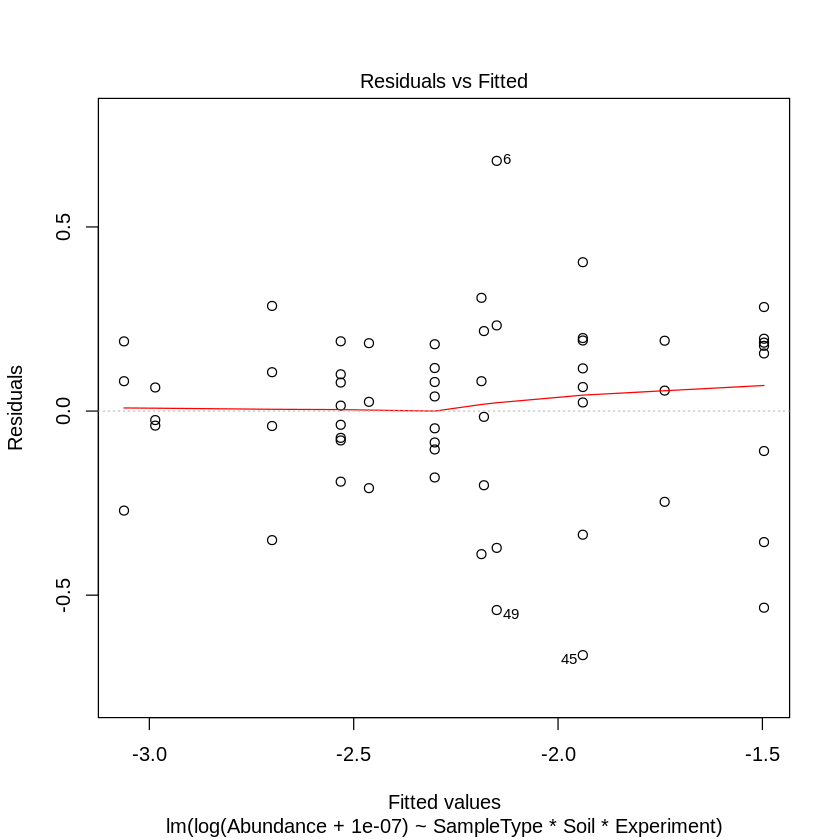

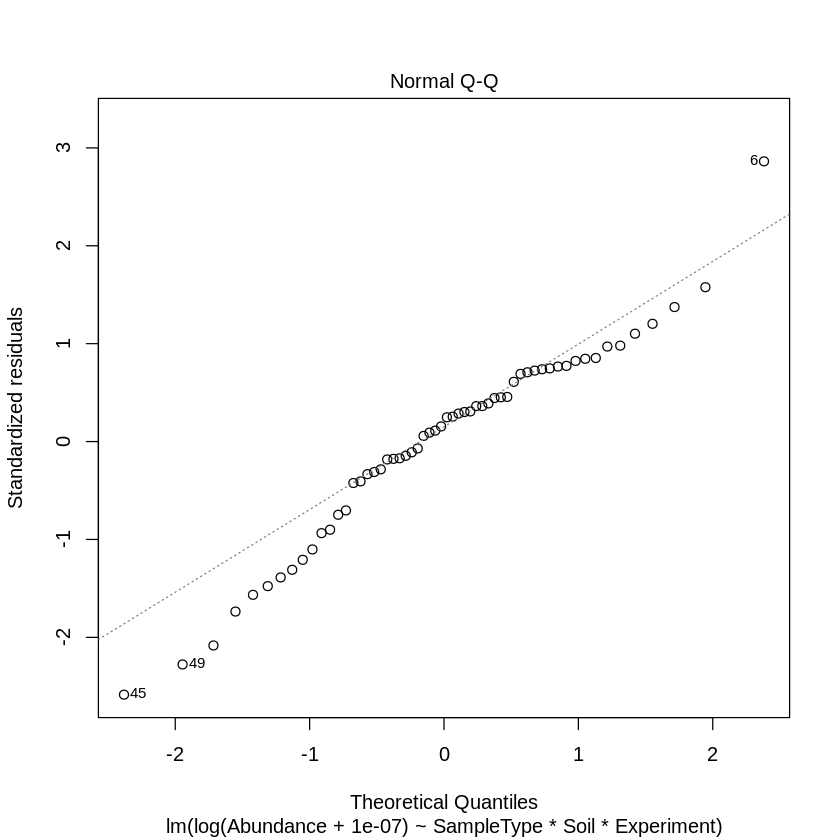

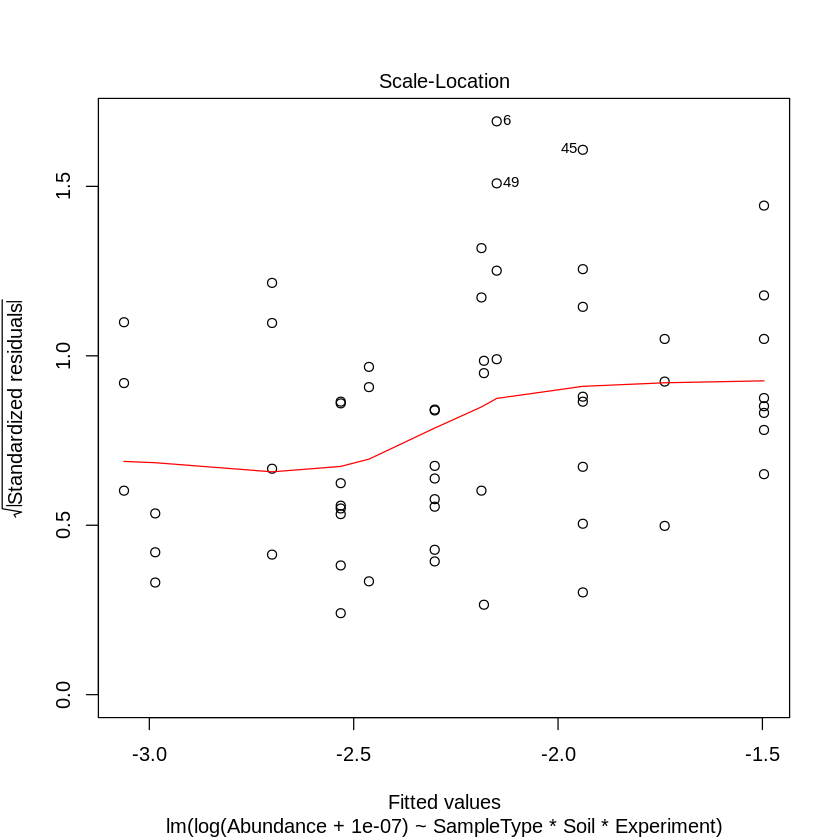

[1] "Rhizobiales"


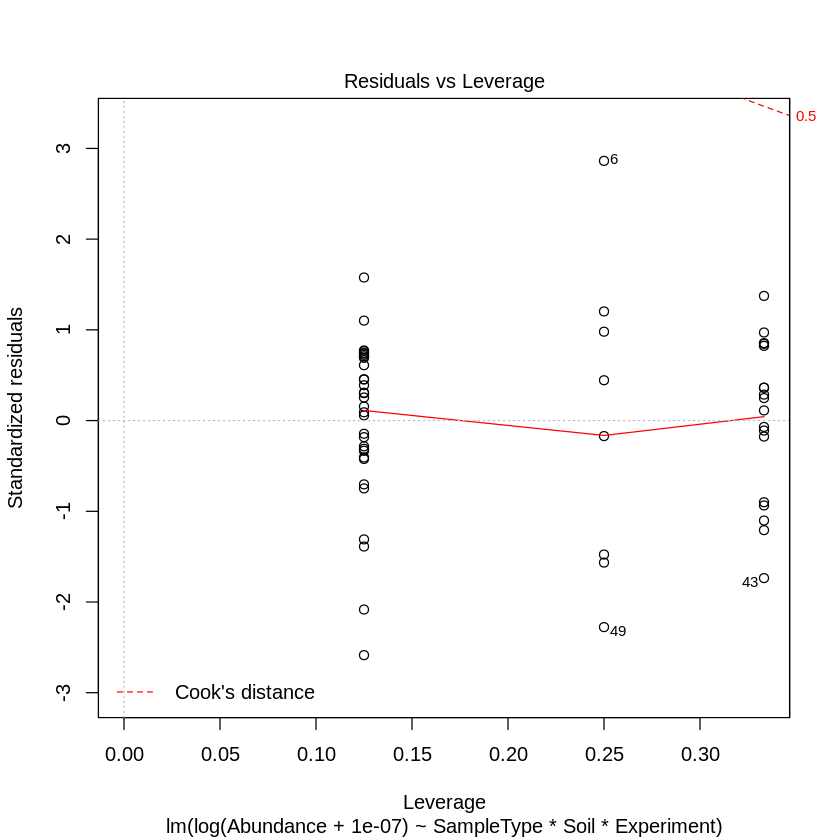

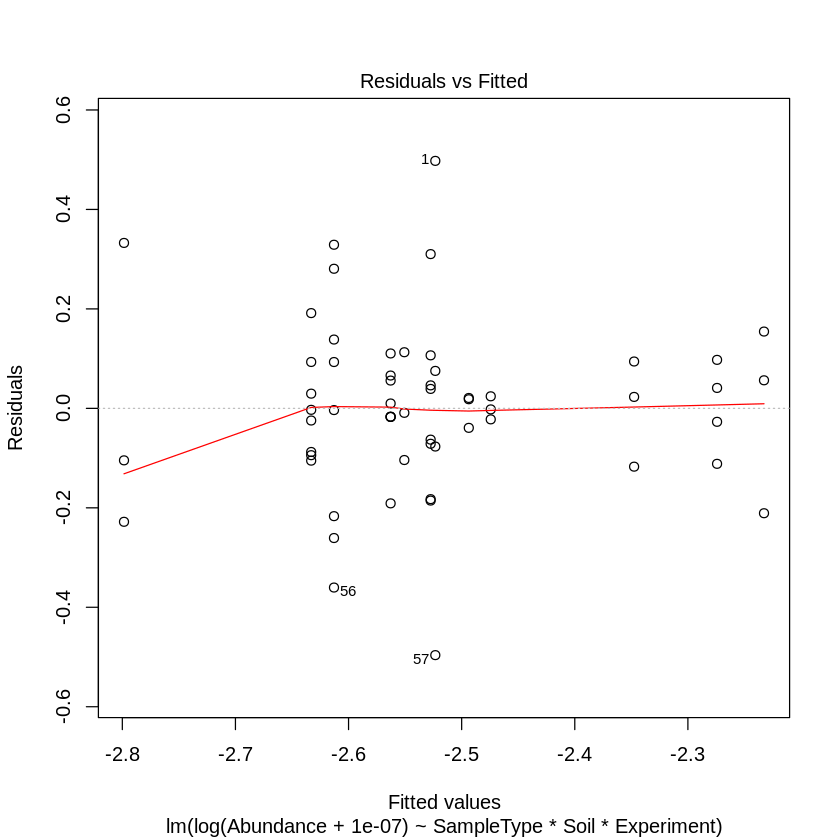

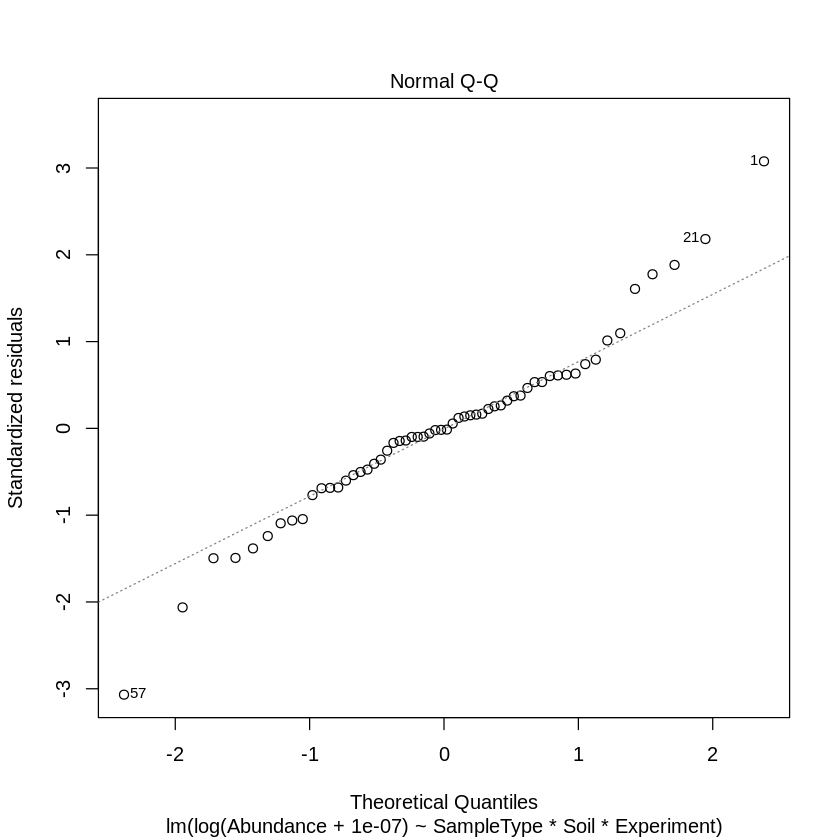

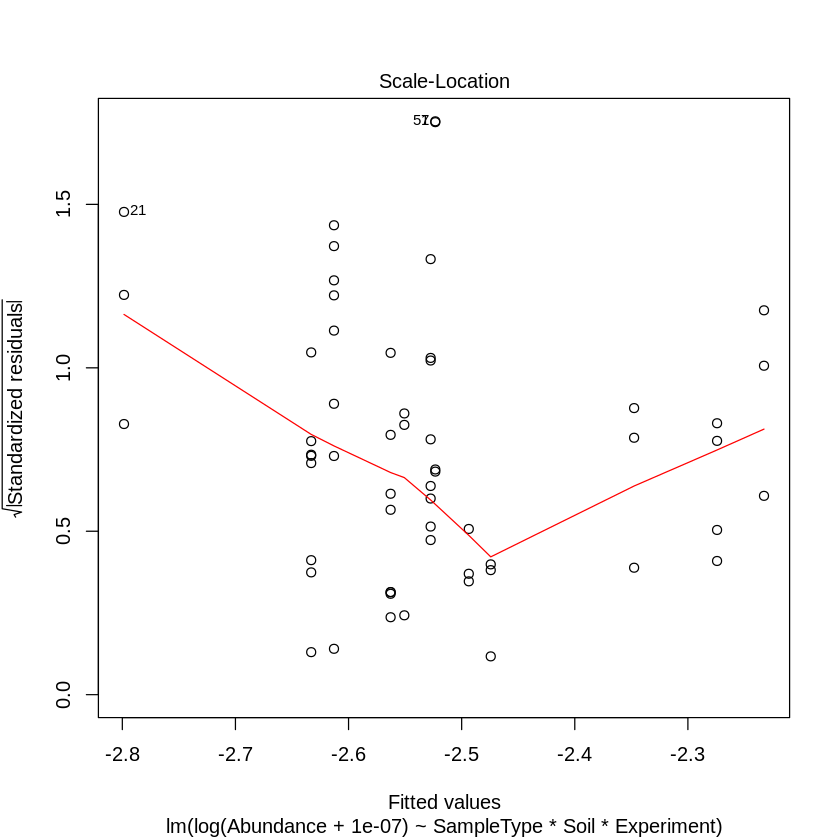

[1] "Myxococcales"


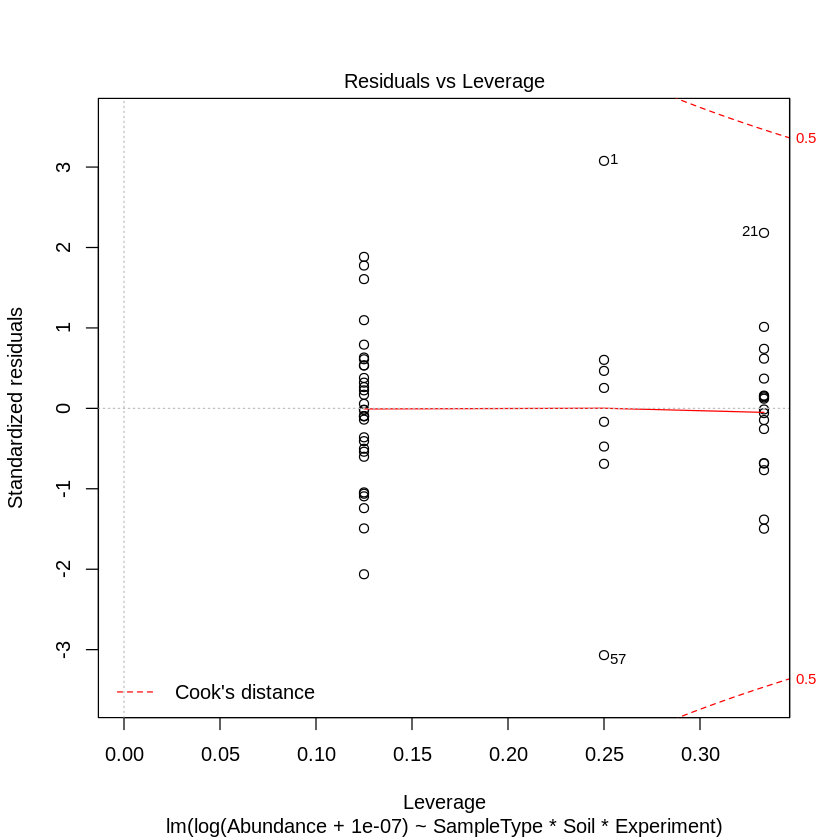

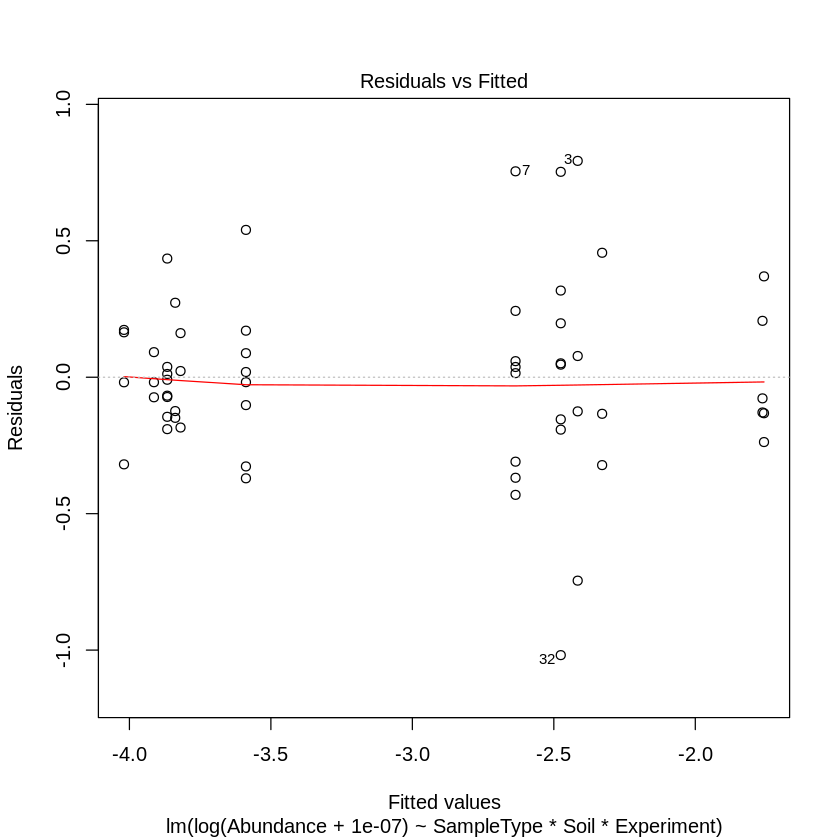

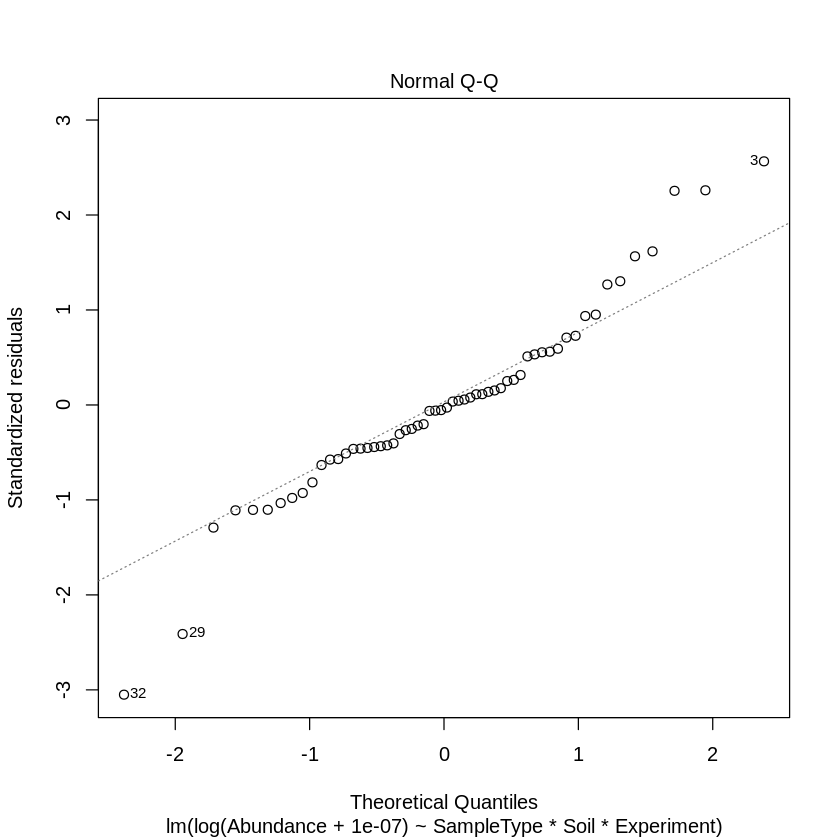

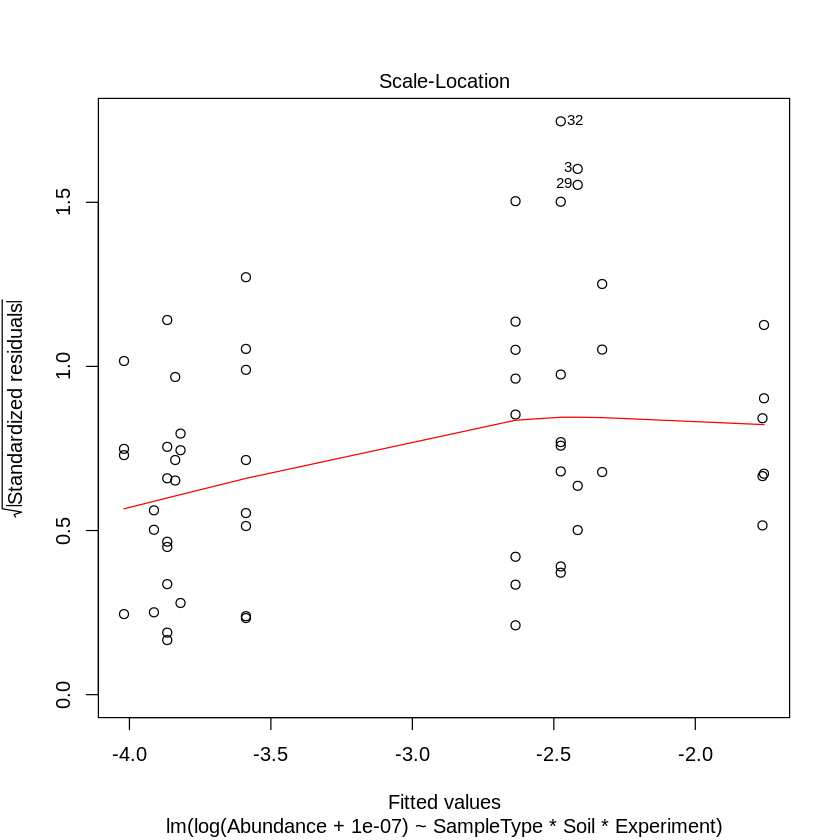

[1] NA


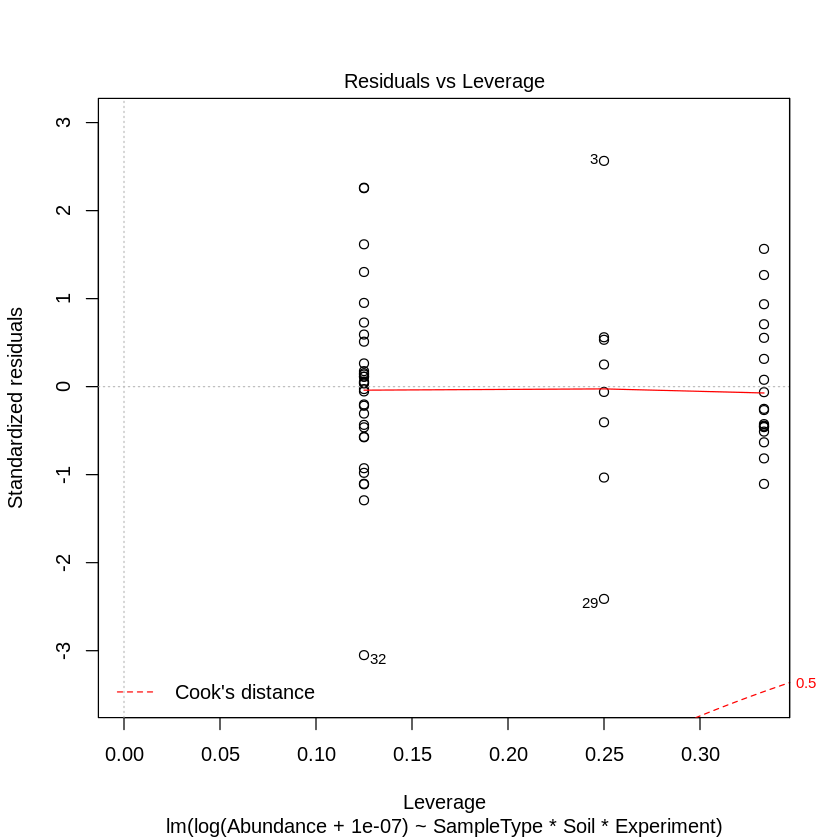

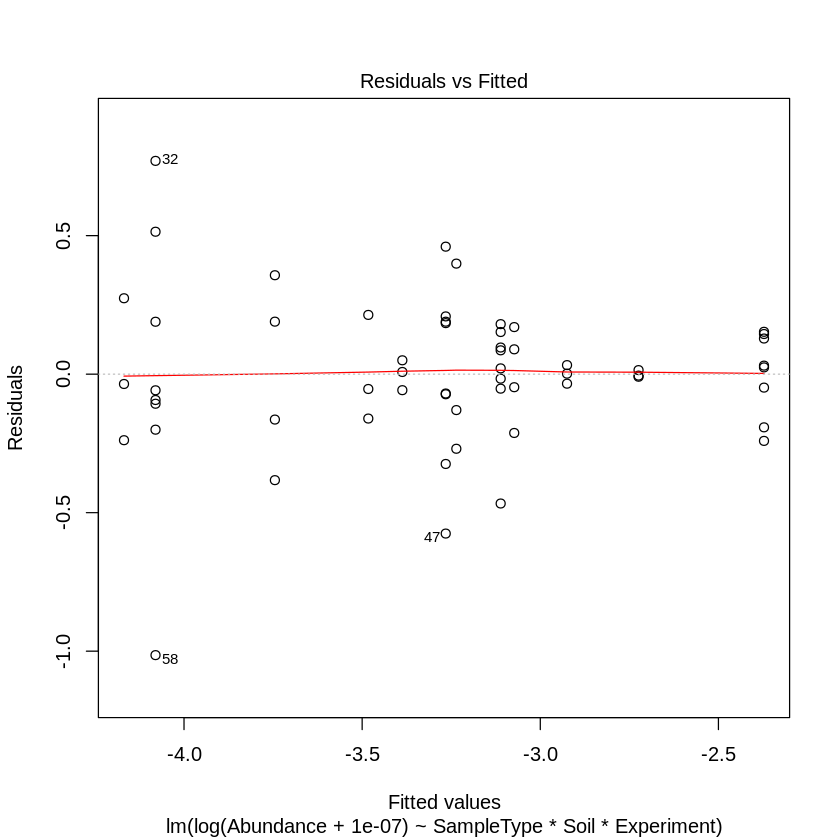

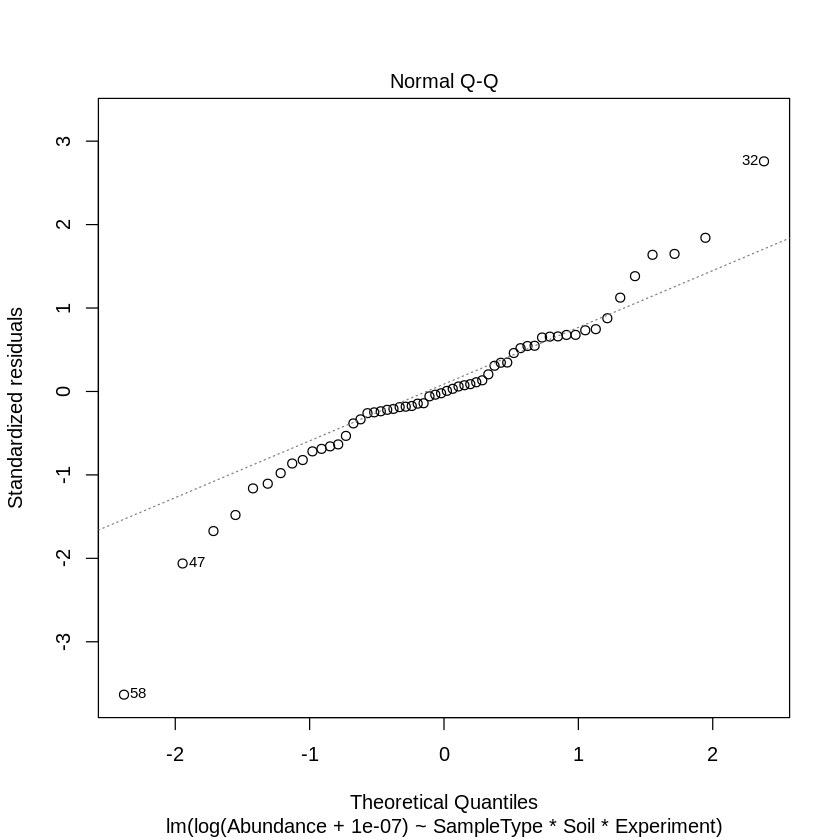

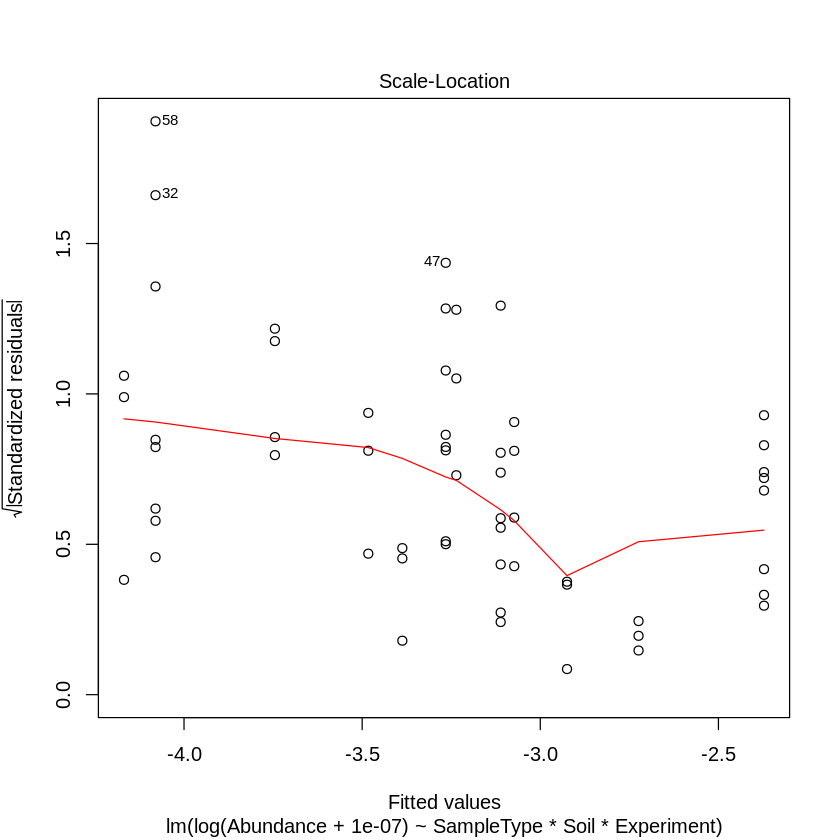

[1] "Caulobacterales"


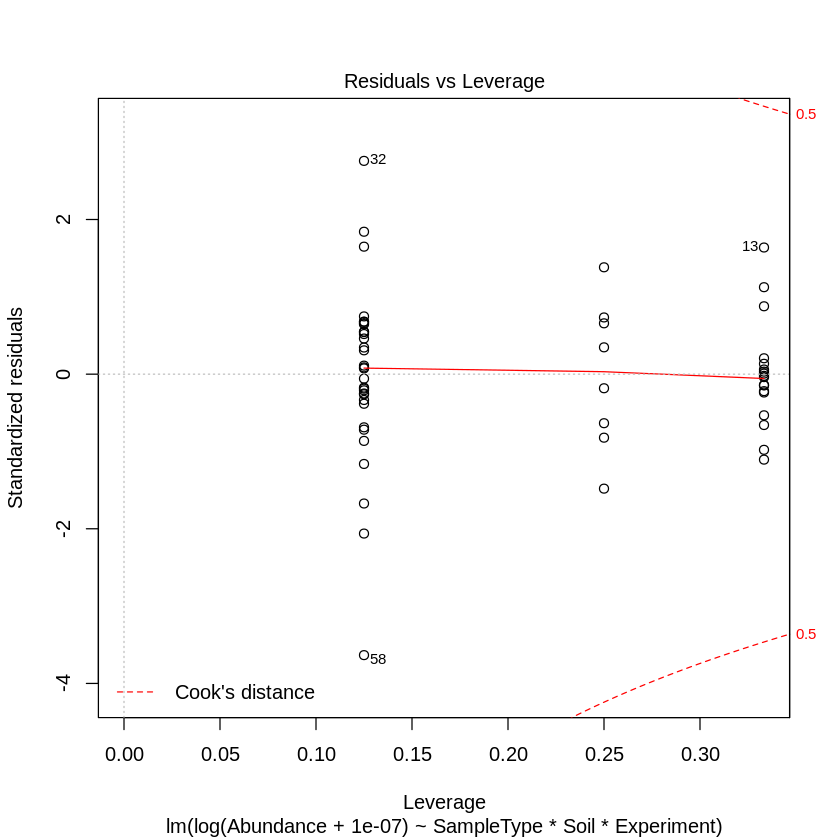

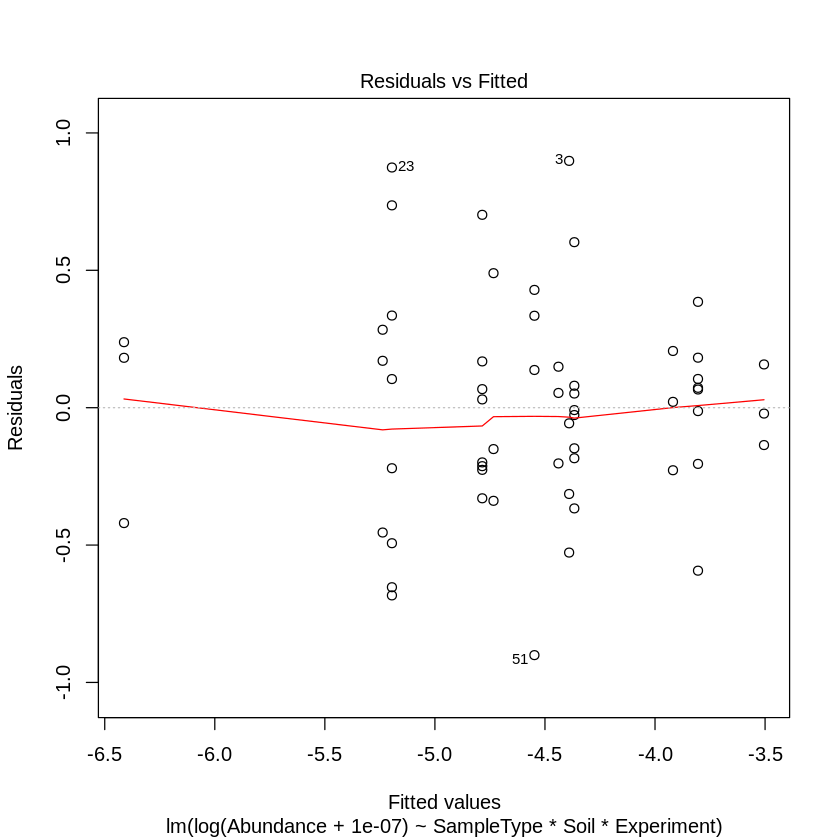

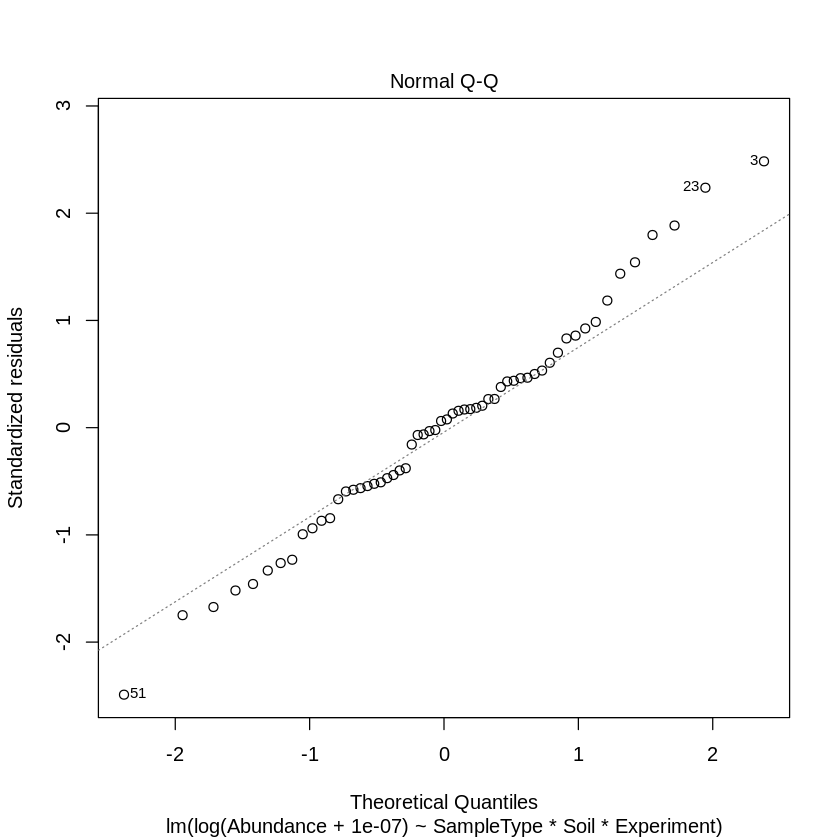

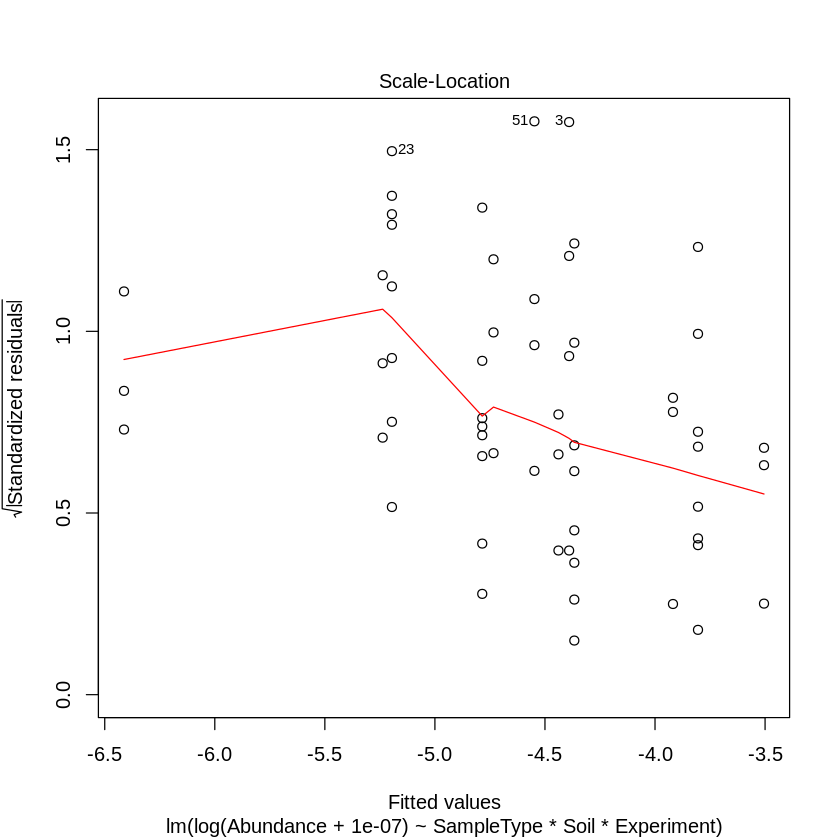

[1] "Cytophagales"


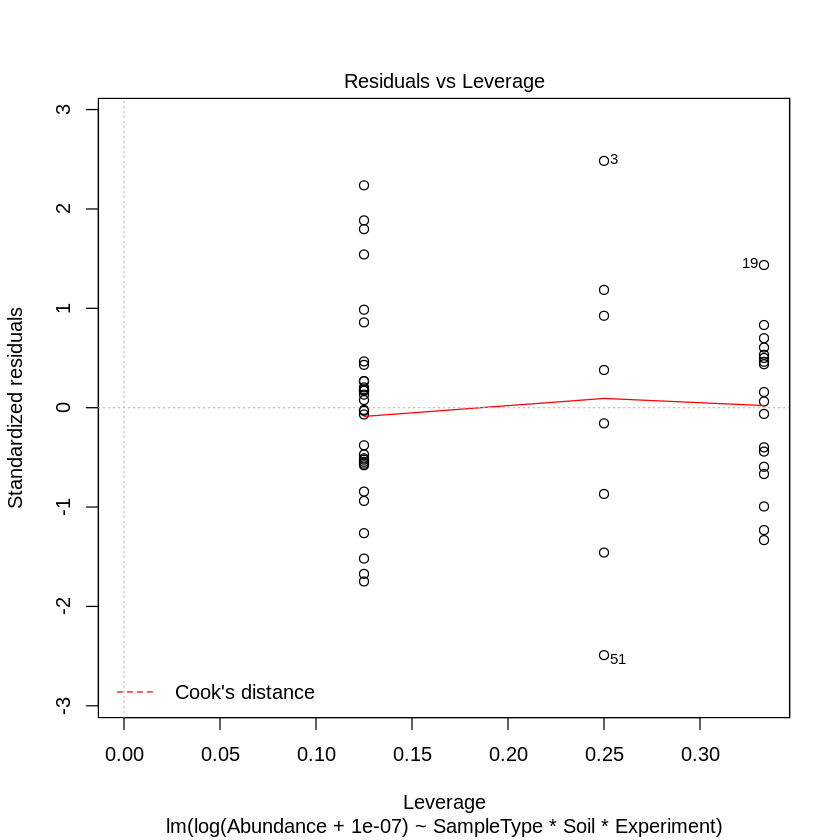

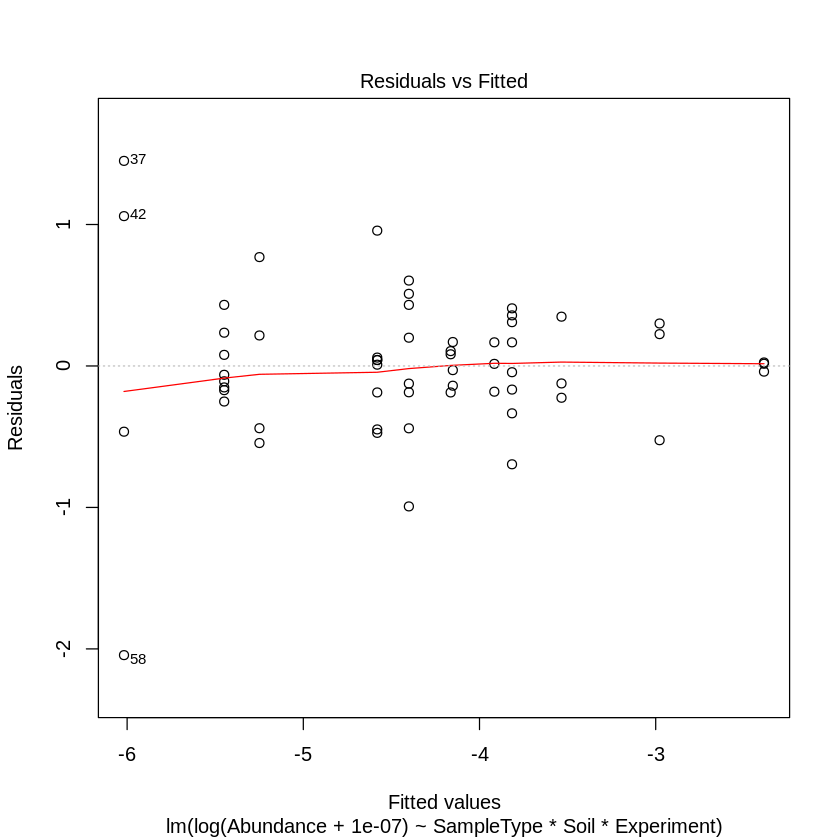

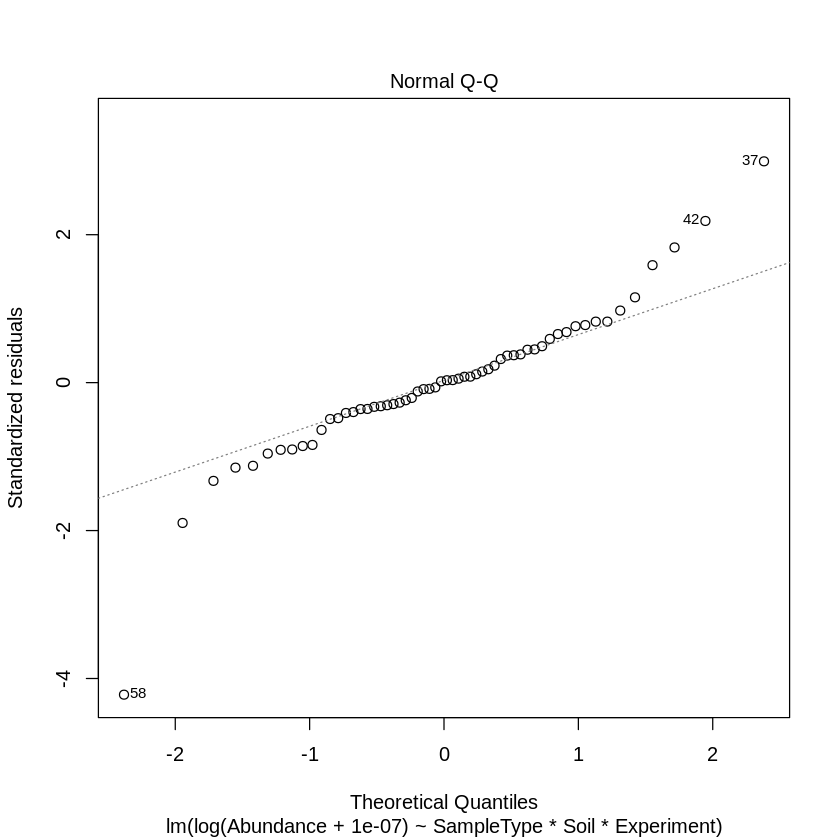

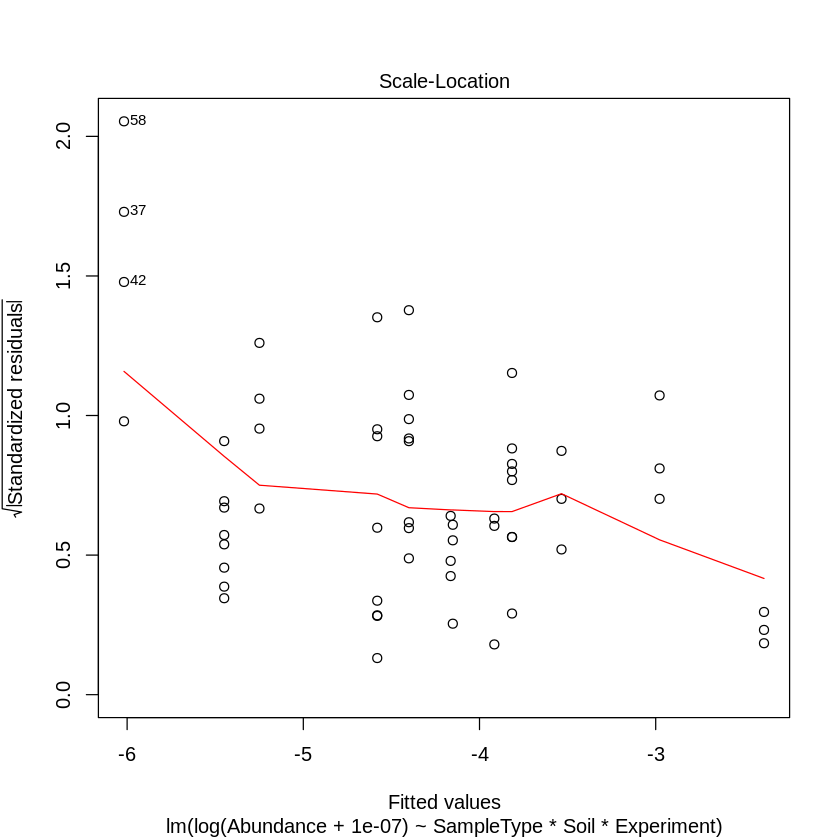

[1] "Micrococcales"


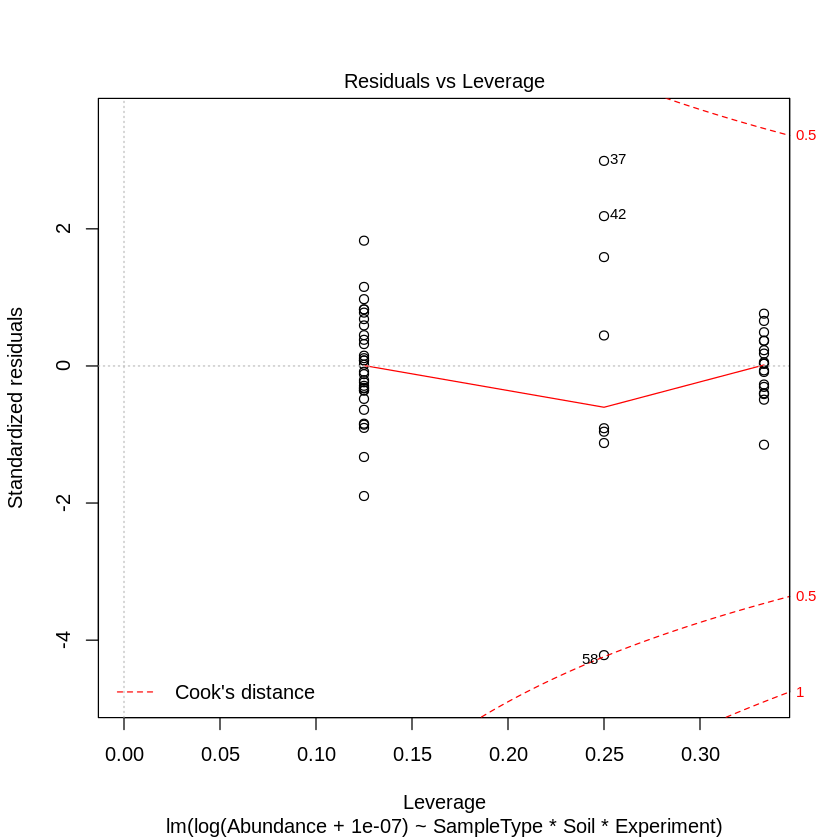

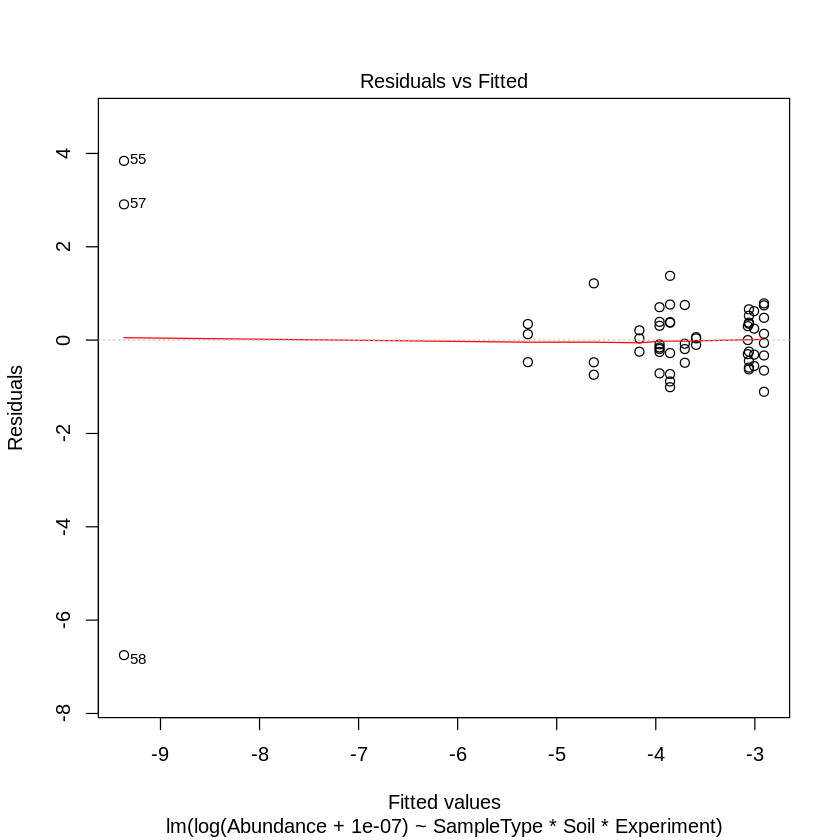

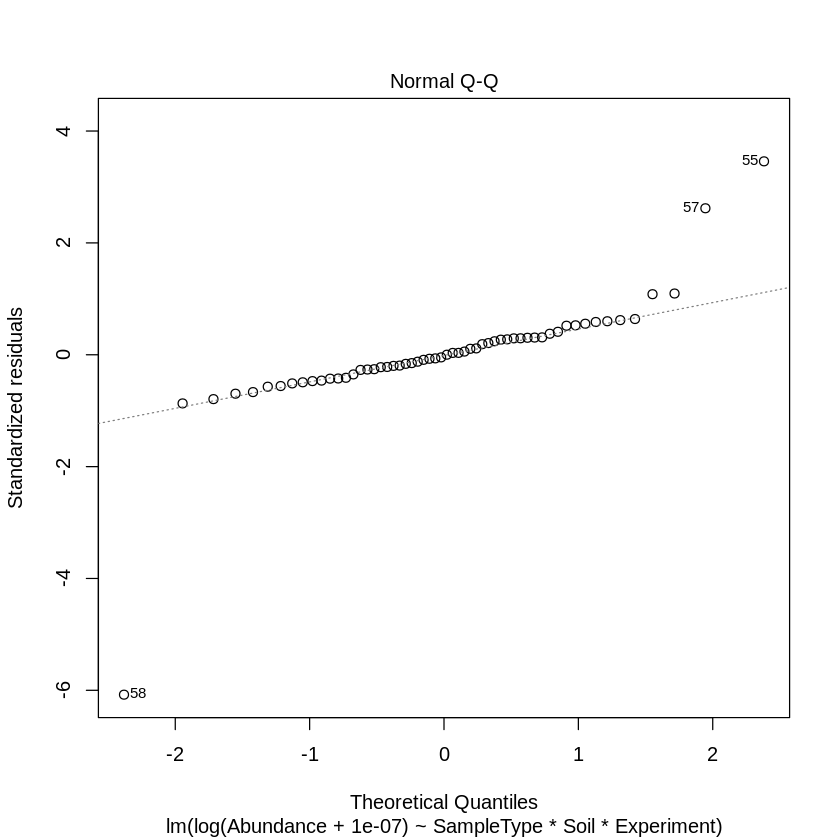

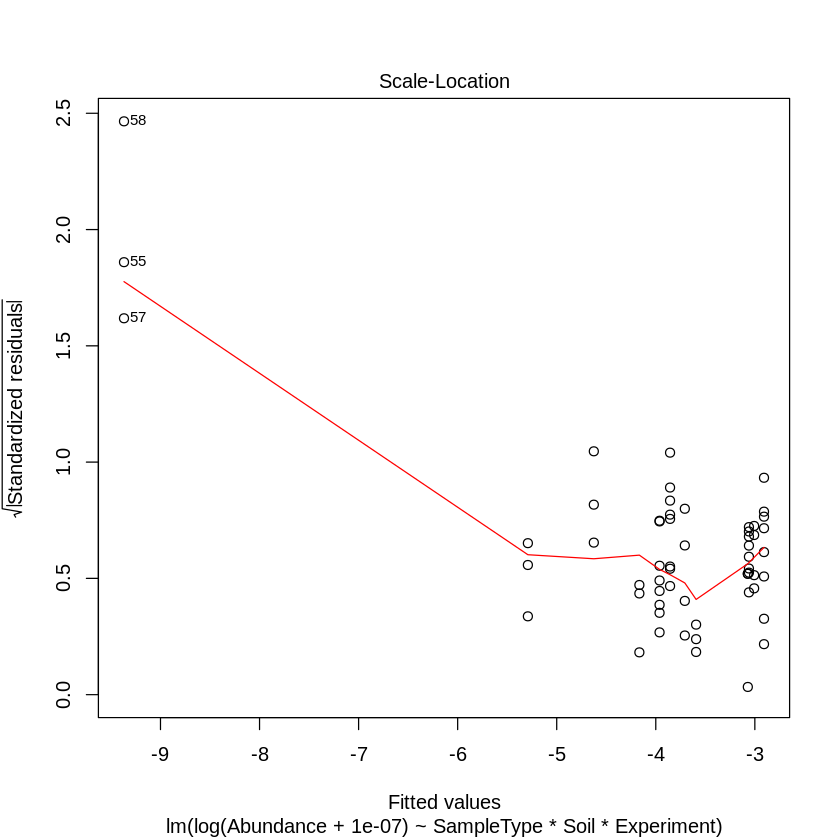

[1] "Gaiellales"


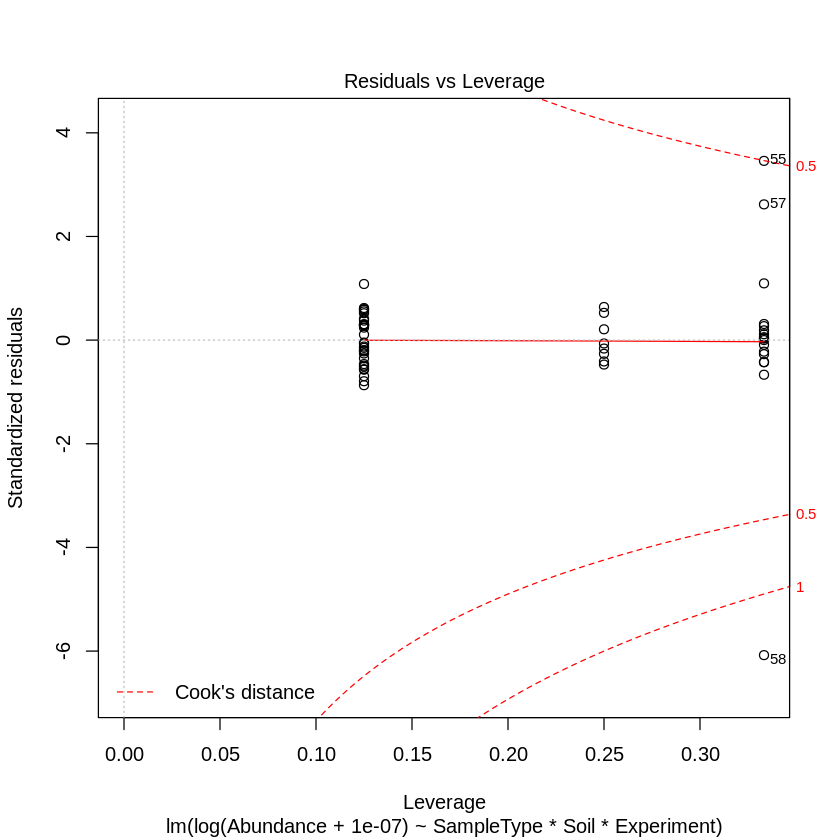

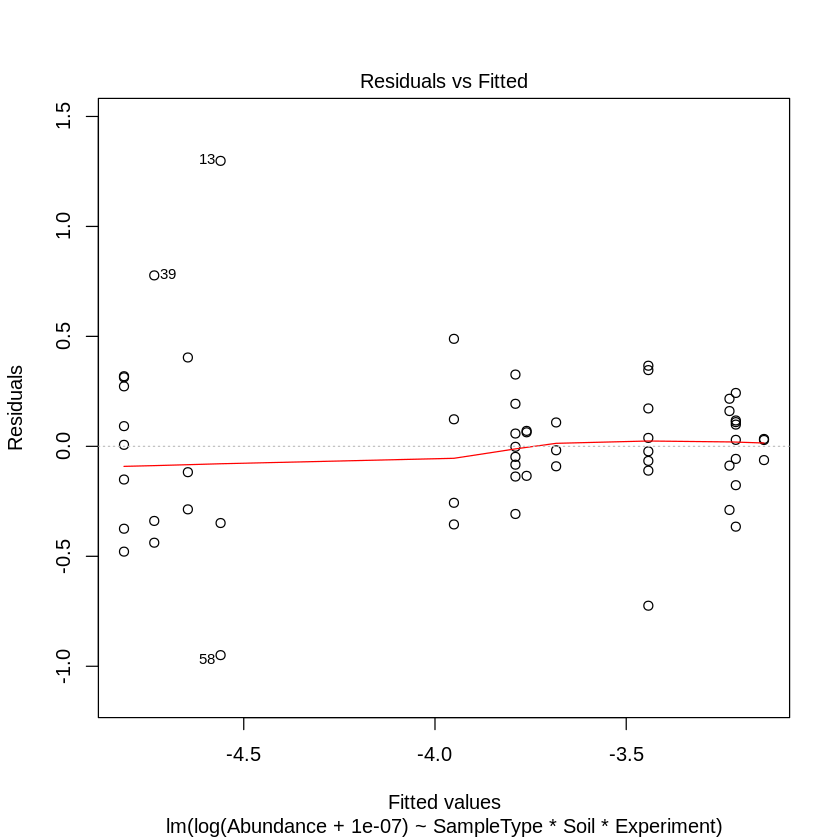

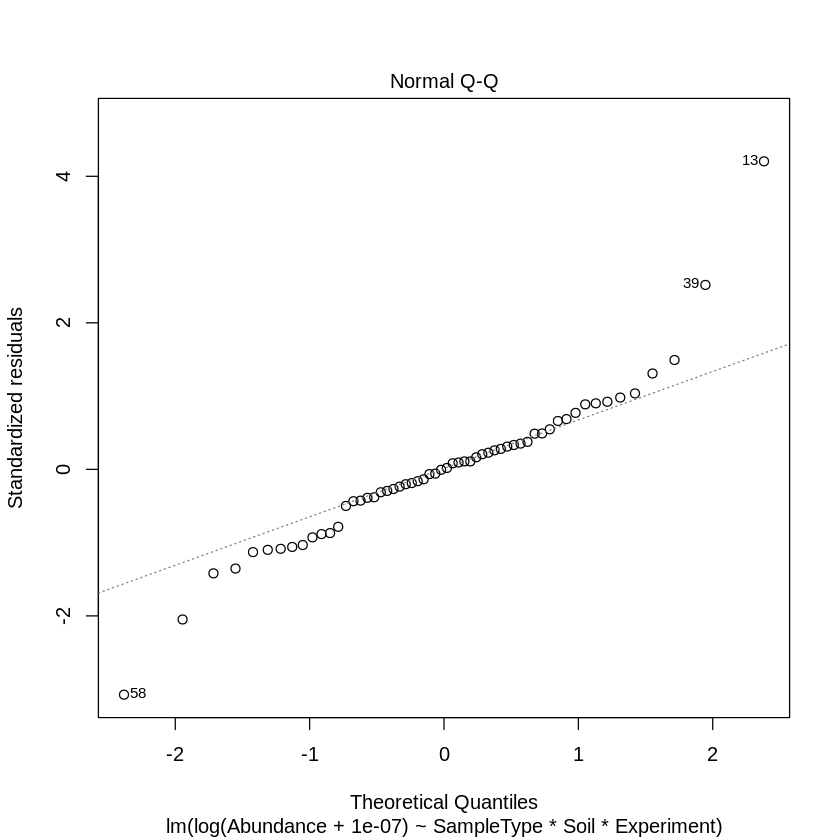

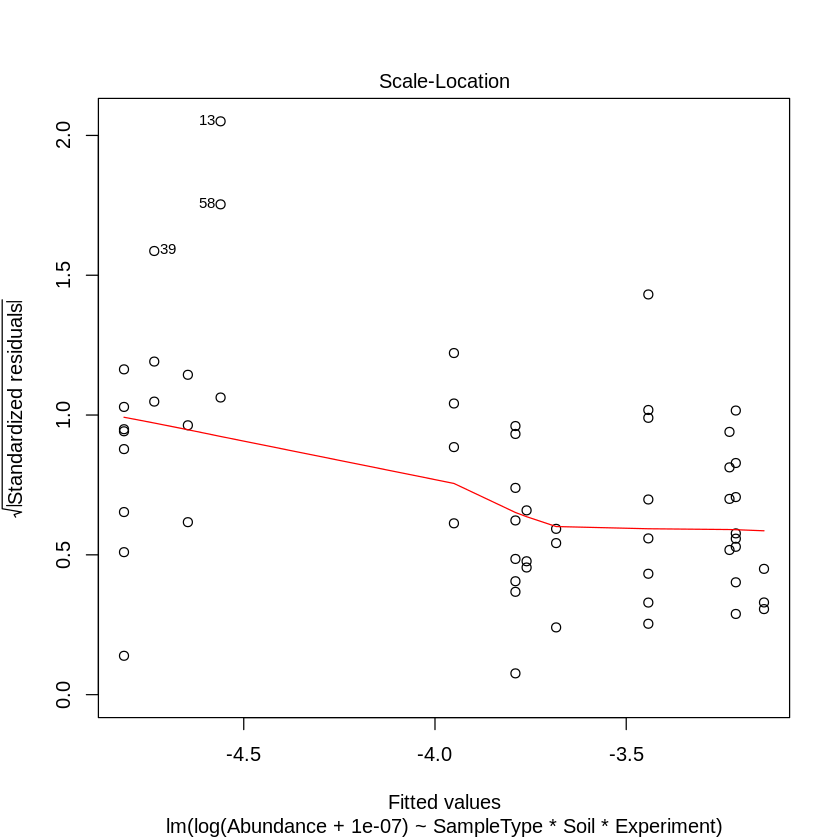

[1] "Gemmatimonadales"


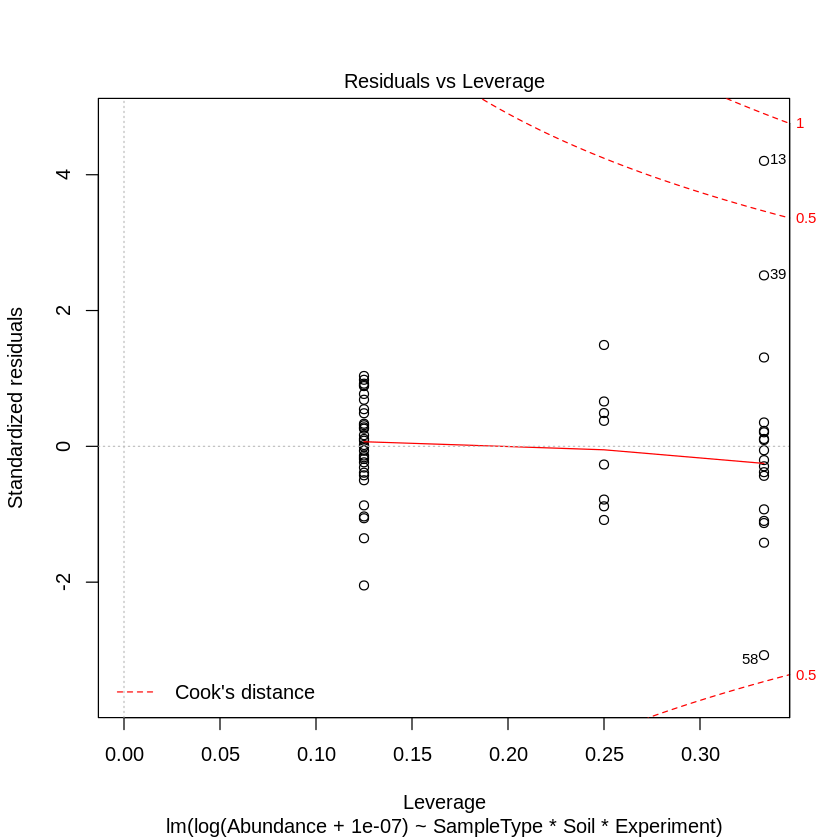

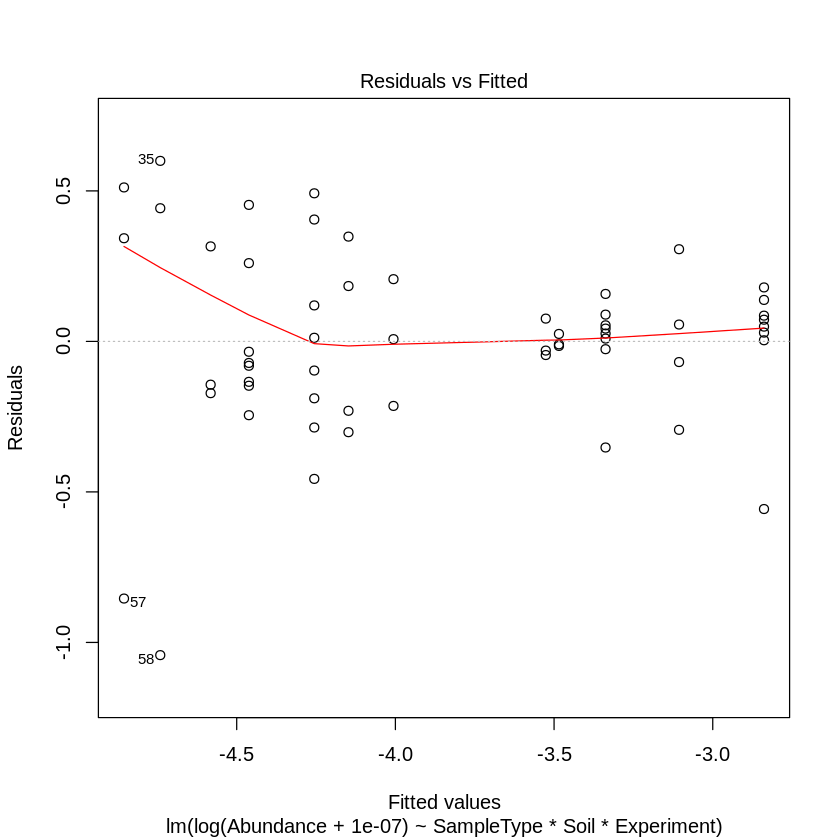

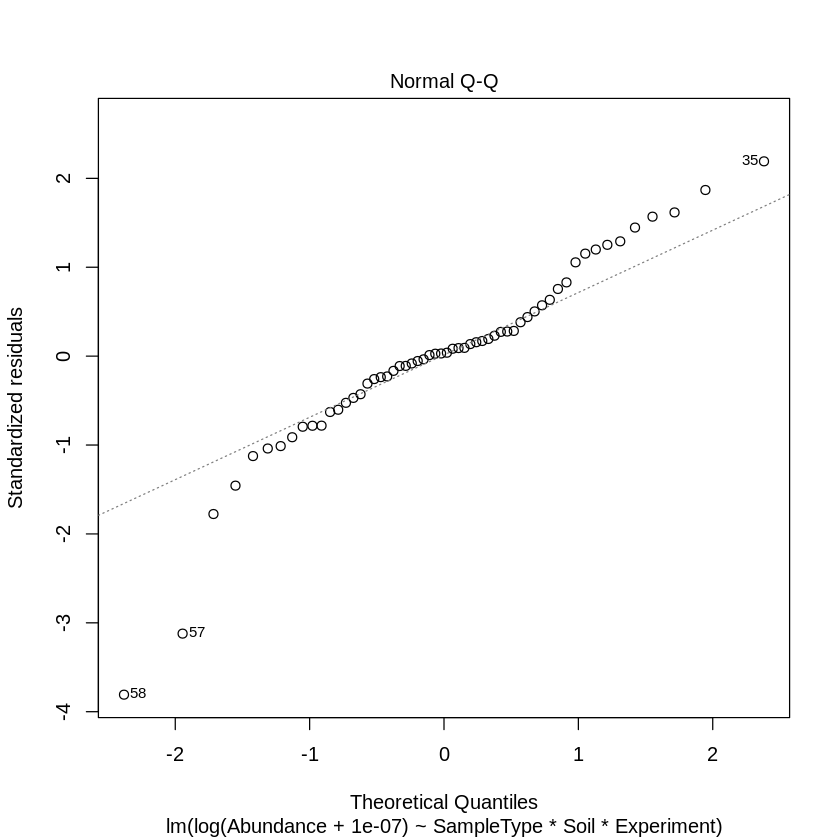

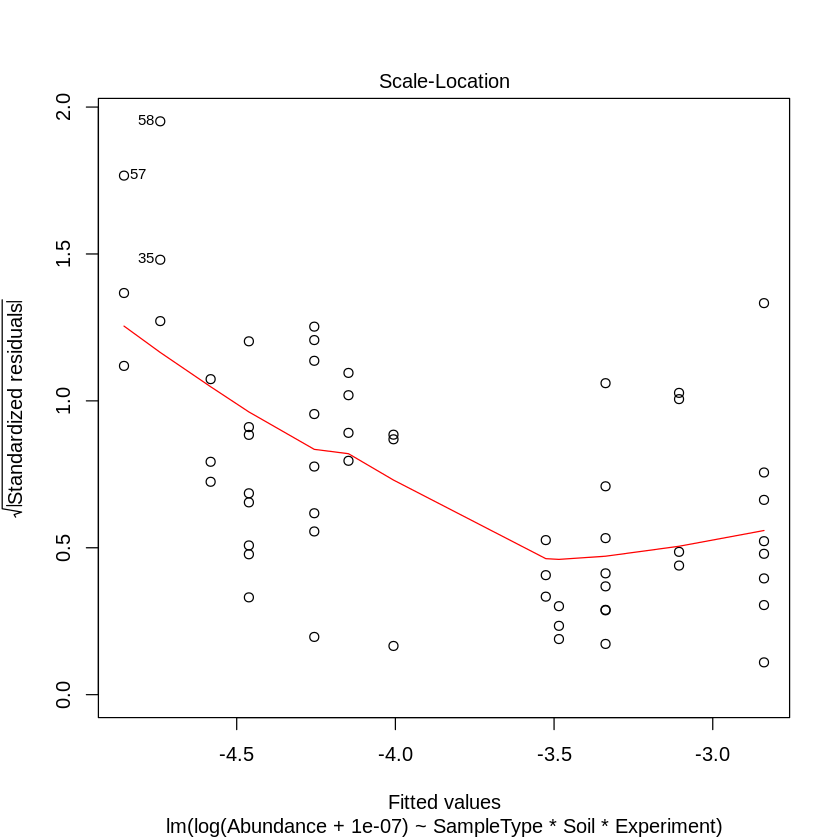

[1] "Nitrososphaerales"


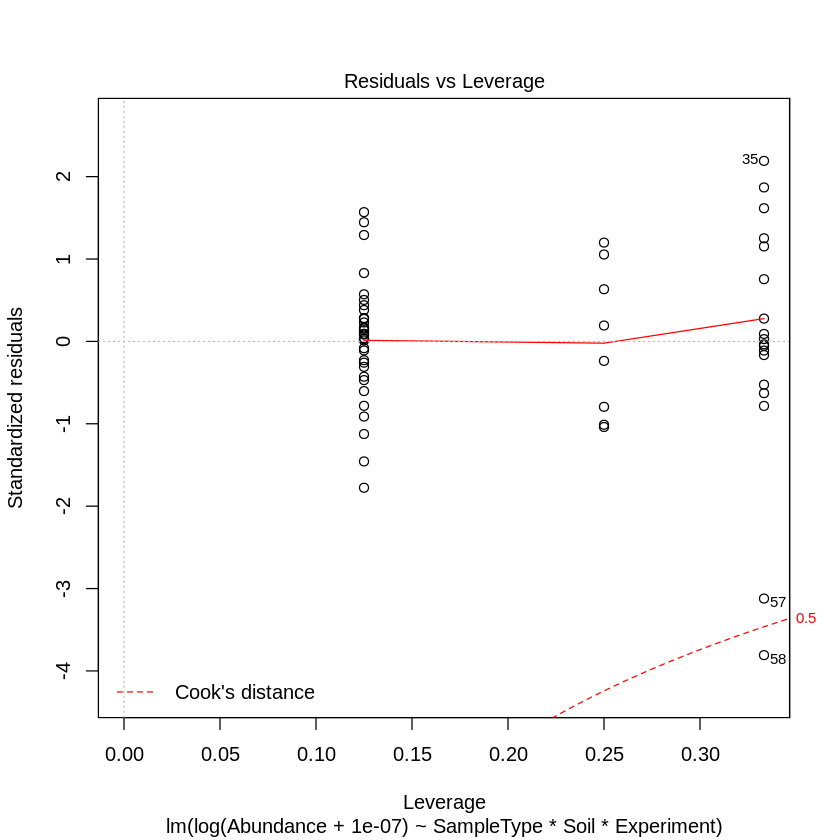

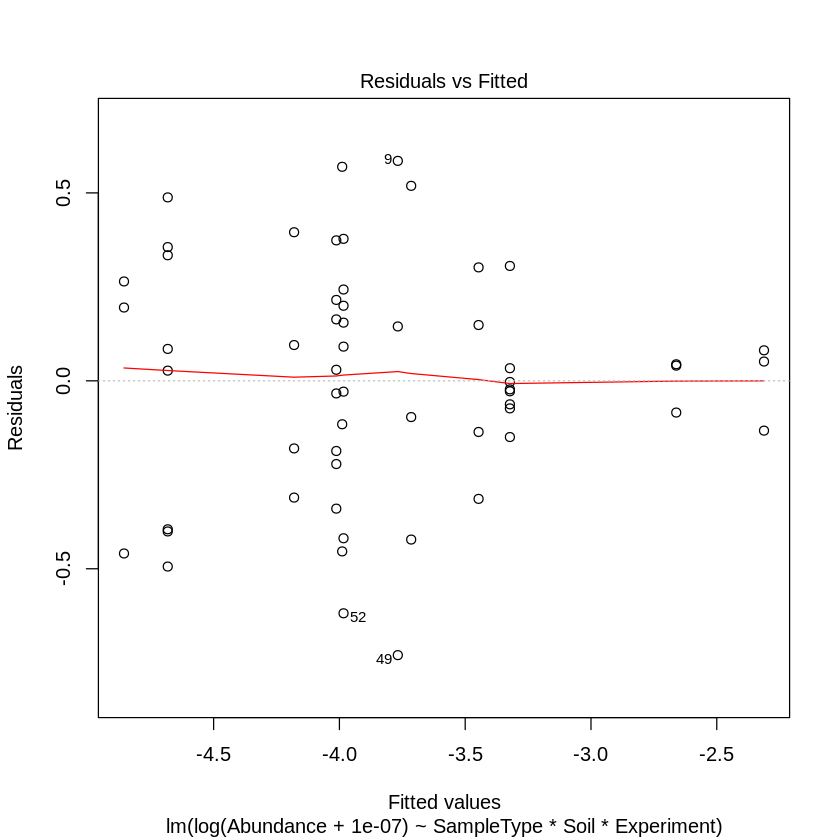

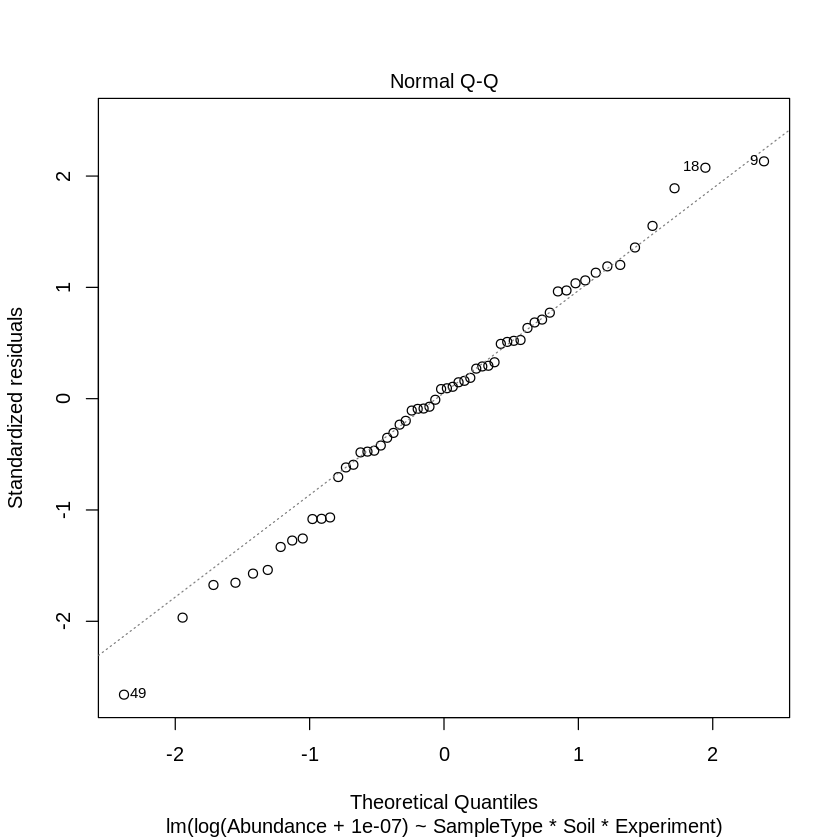

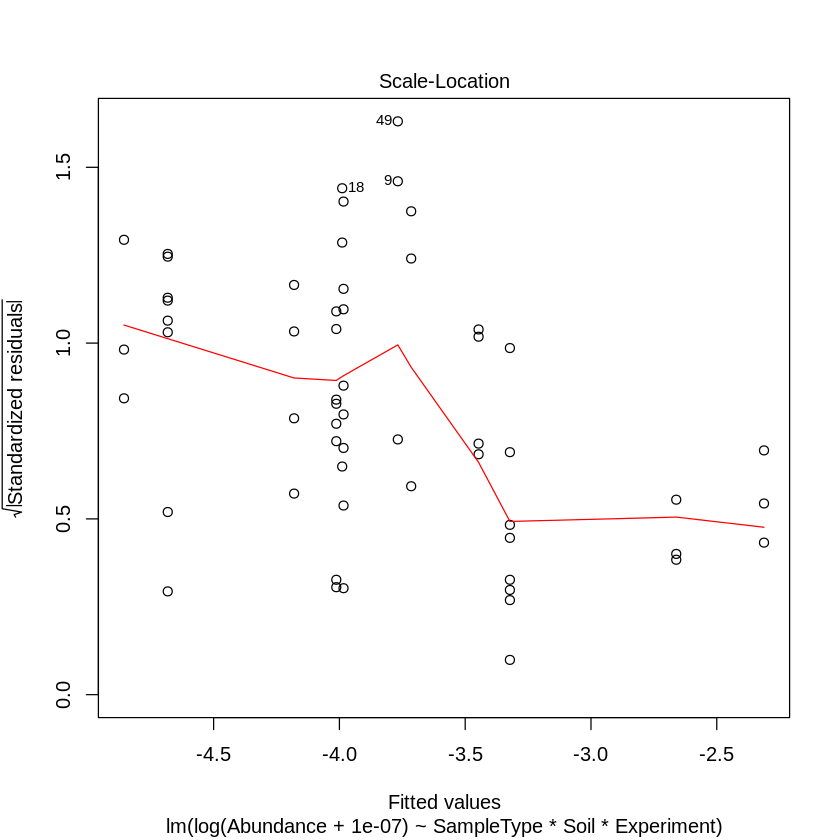

[1] "Fibrobacterales"


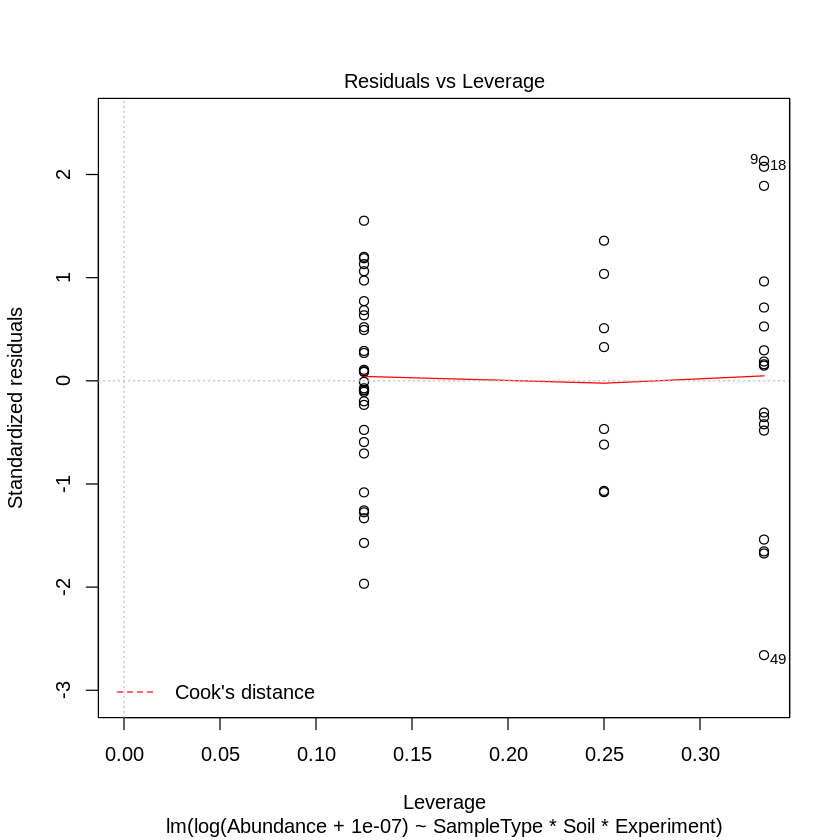

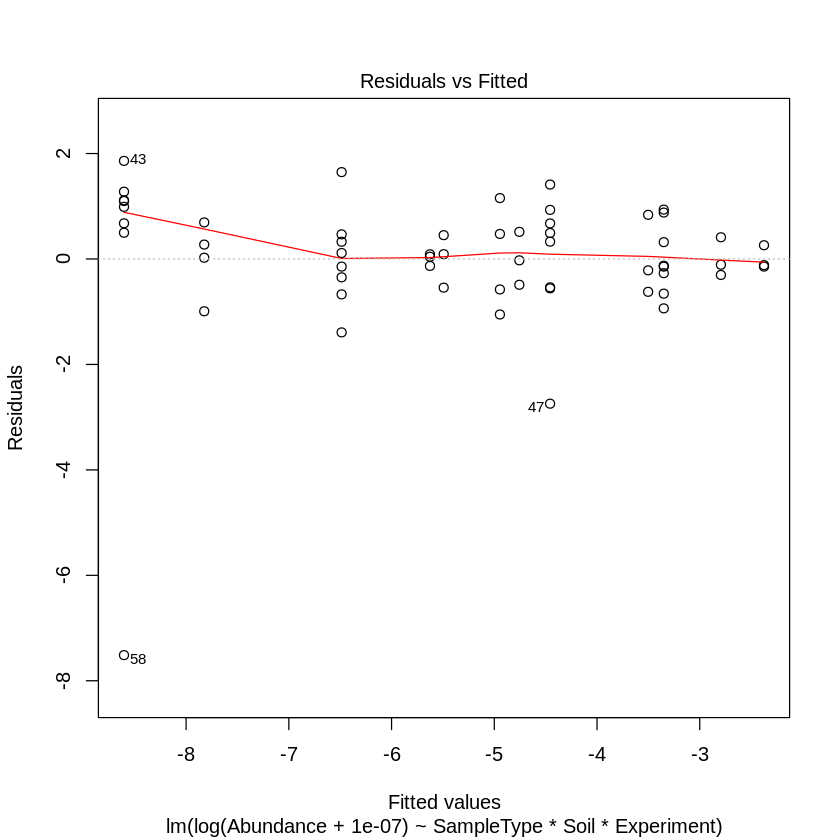

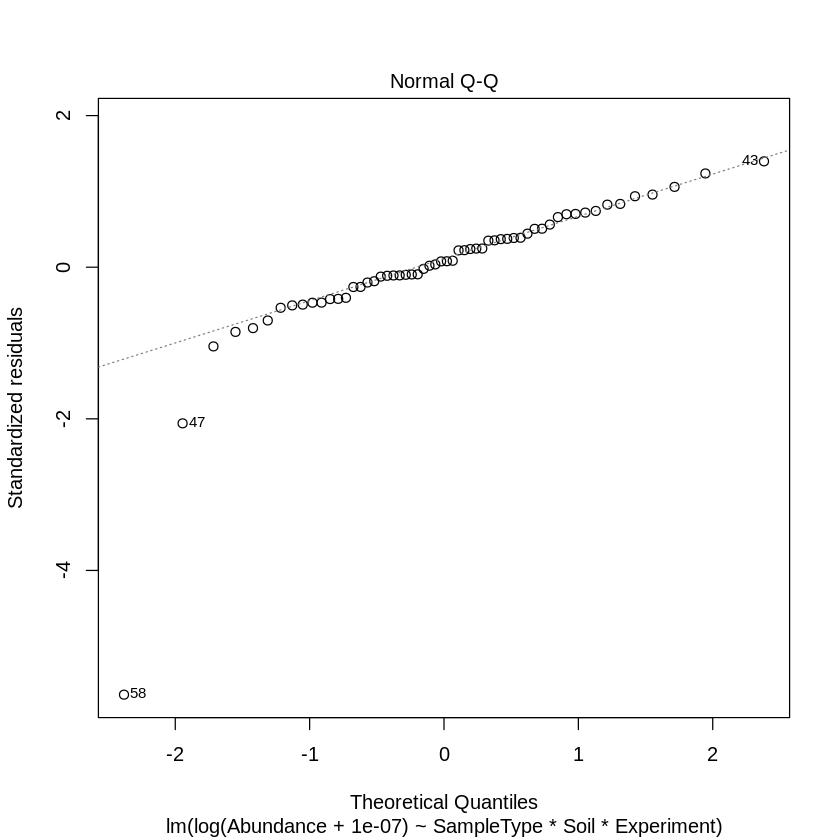

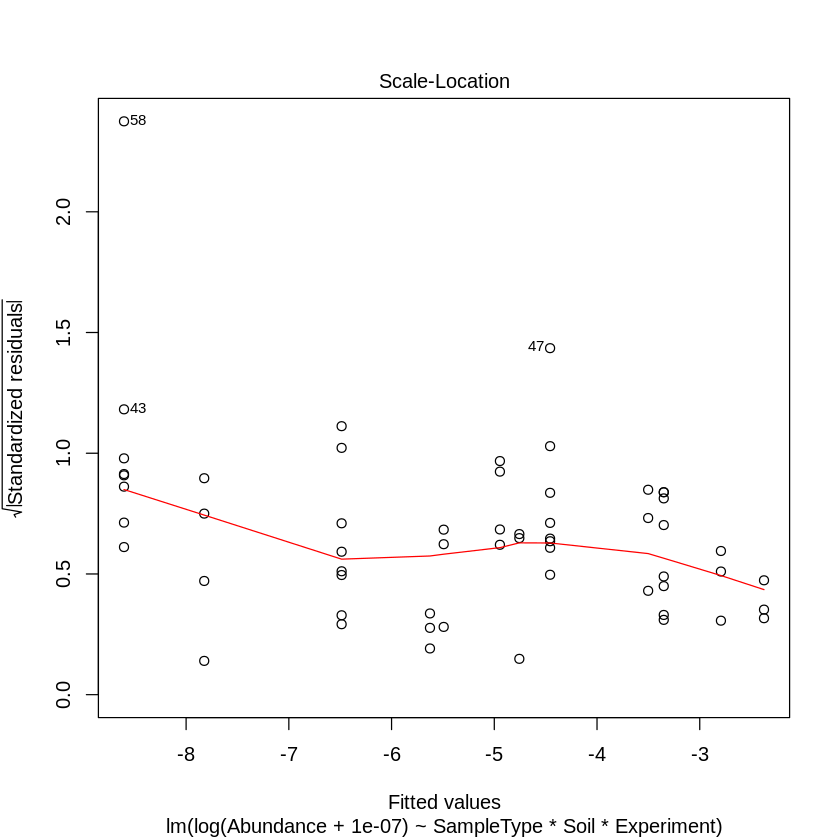

[1] "Sphingomonadales"


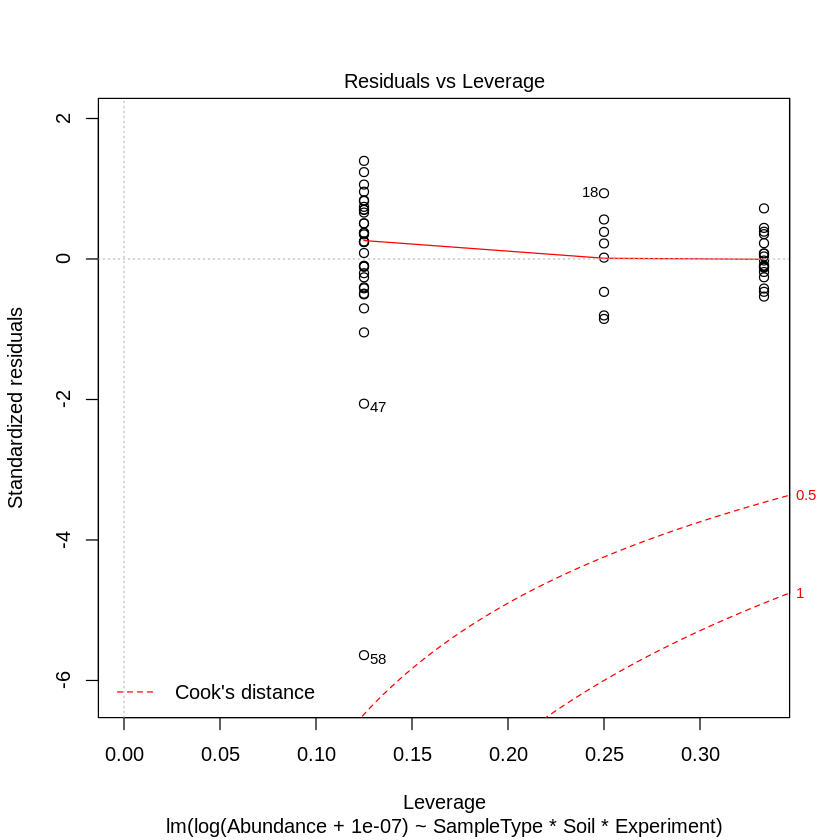

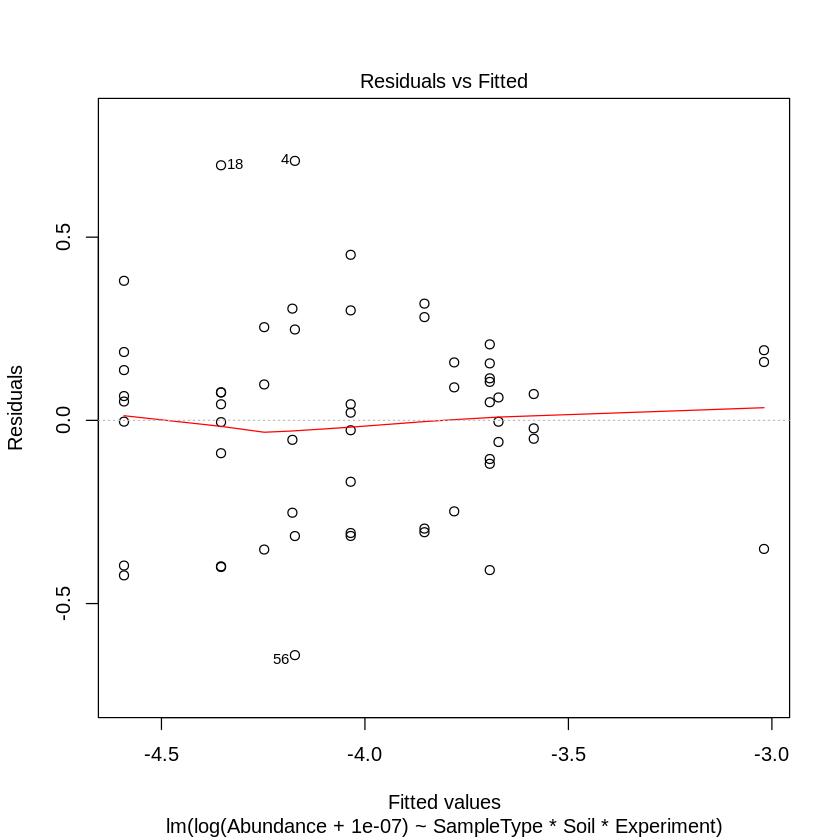

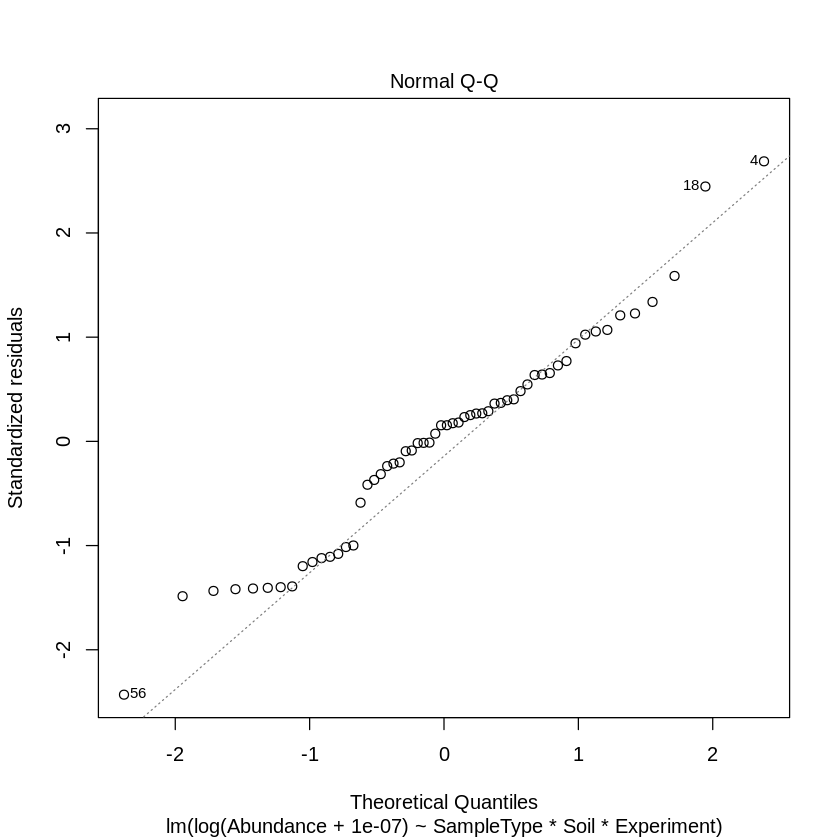

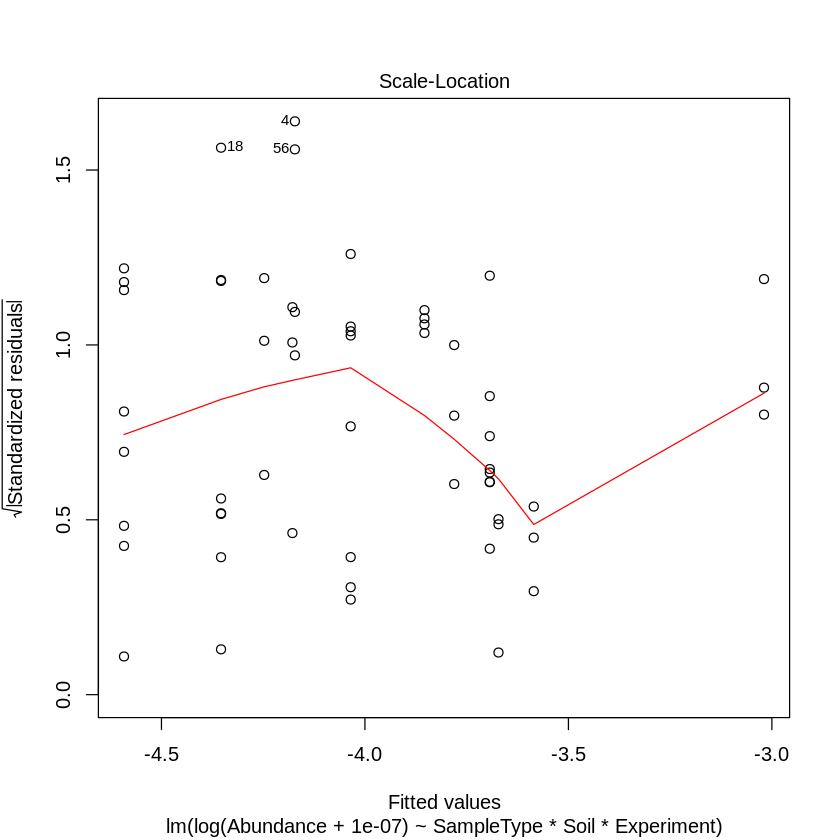

[1] "Chthoniobacterales"


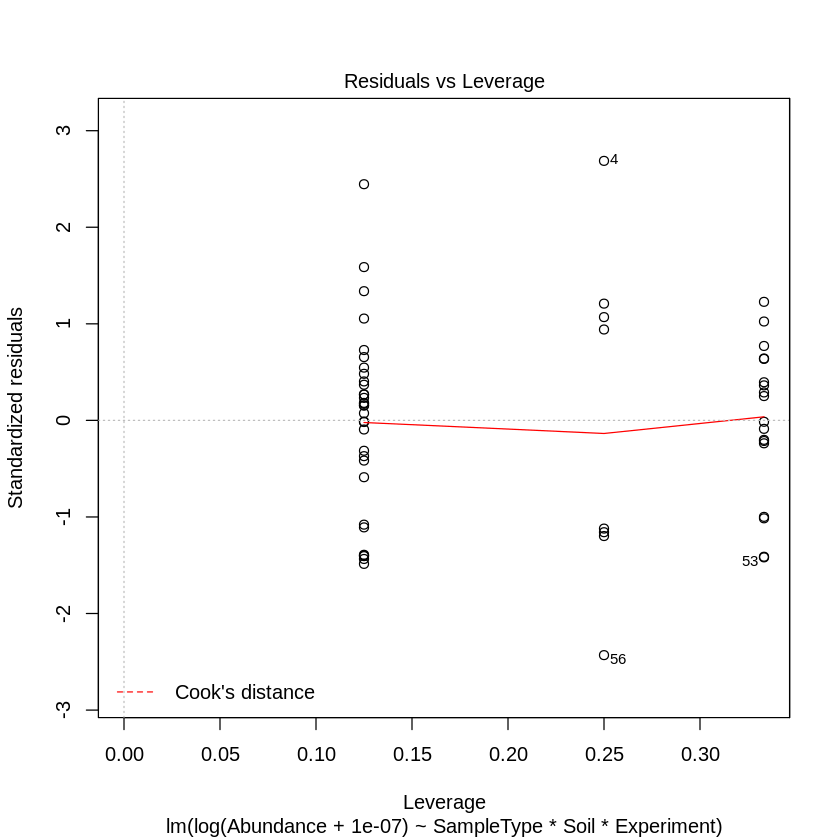

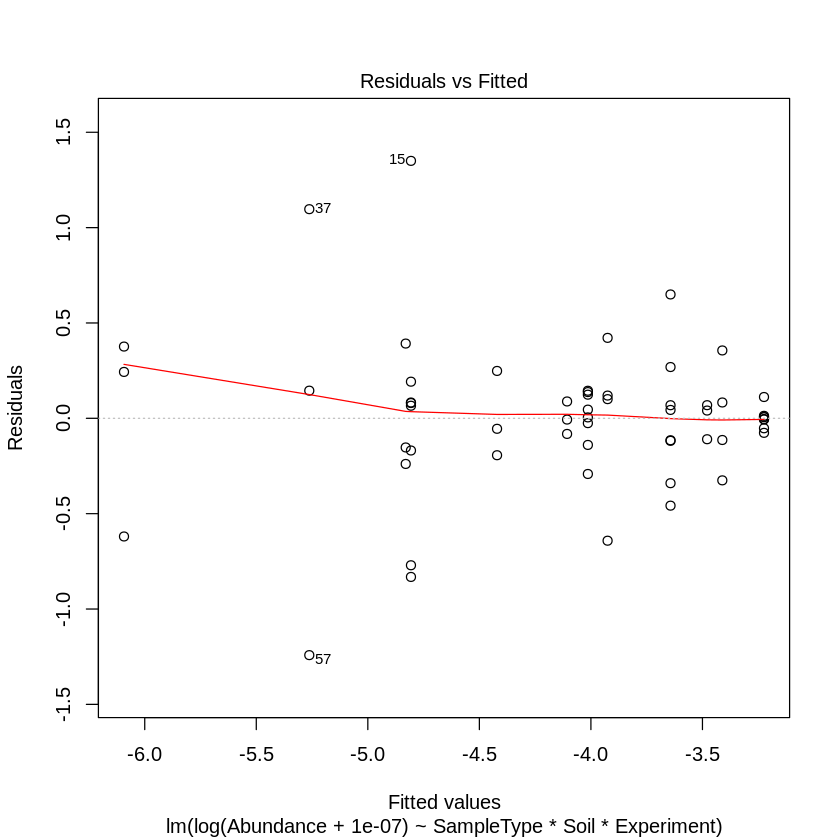

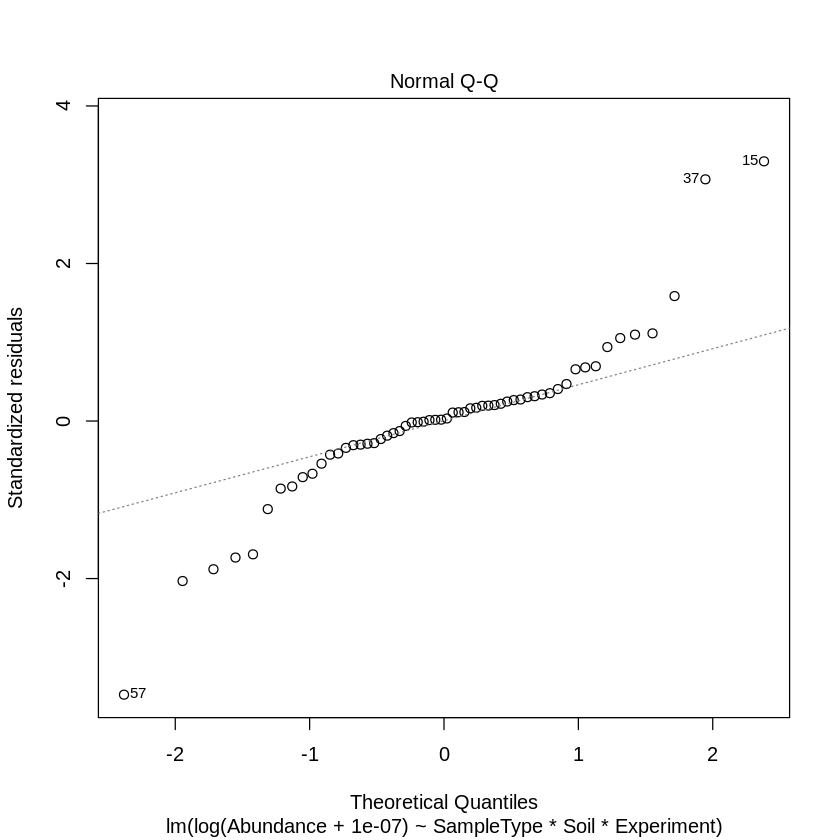

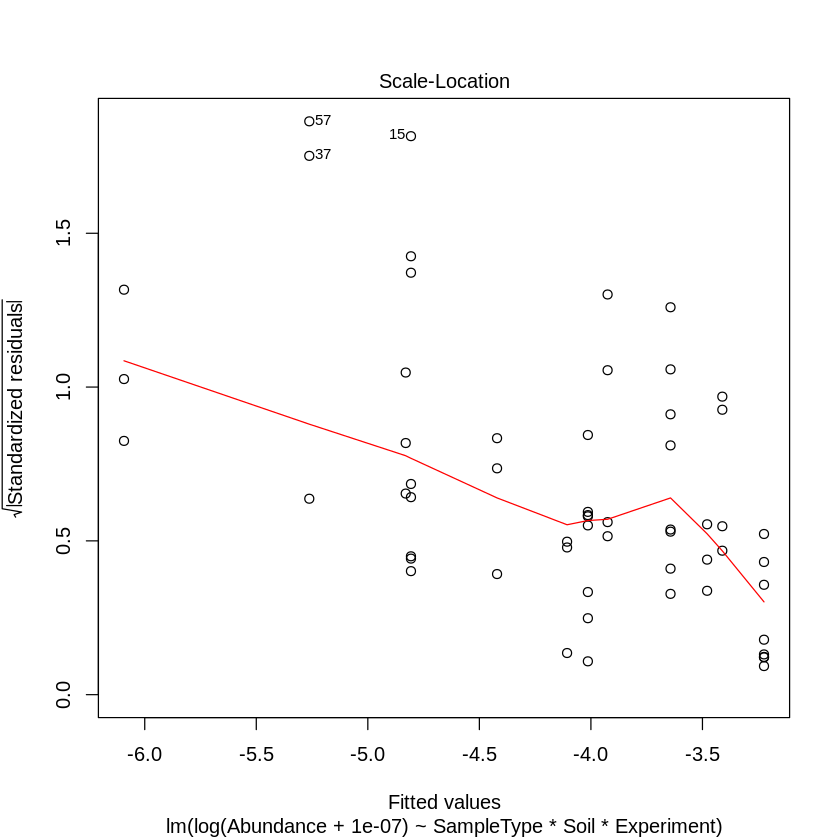

[1] "Xanthomonadales"


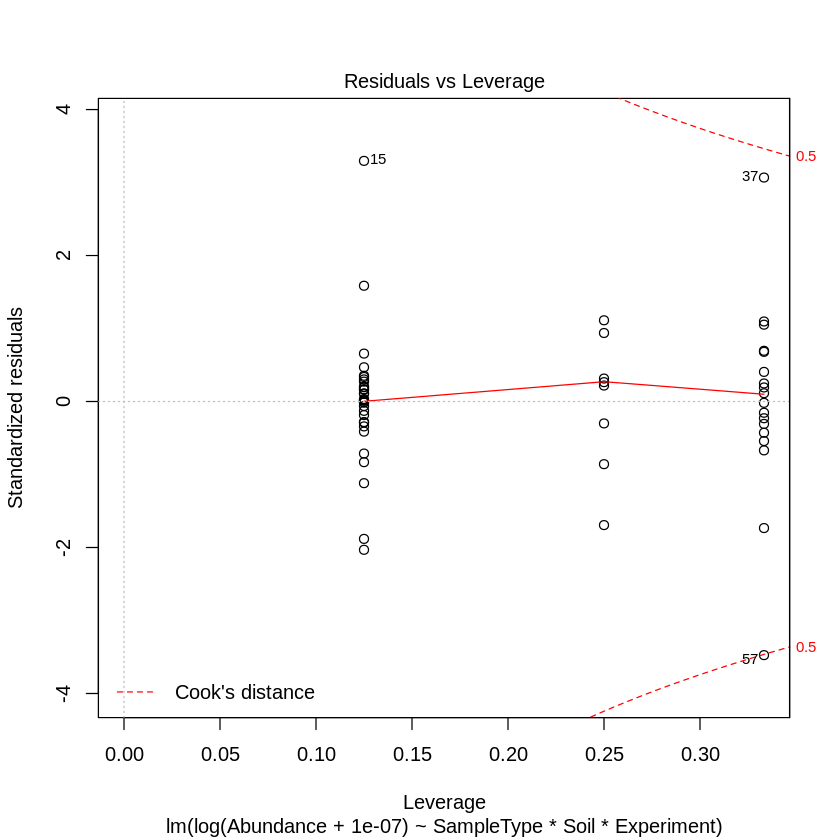

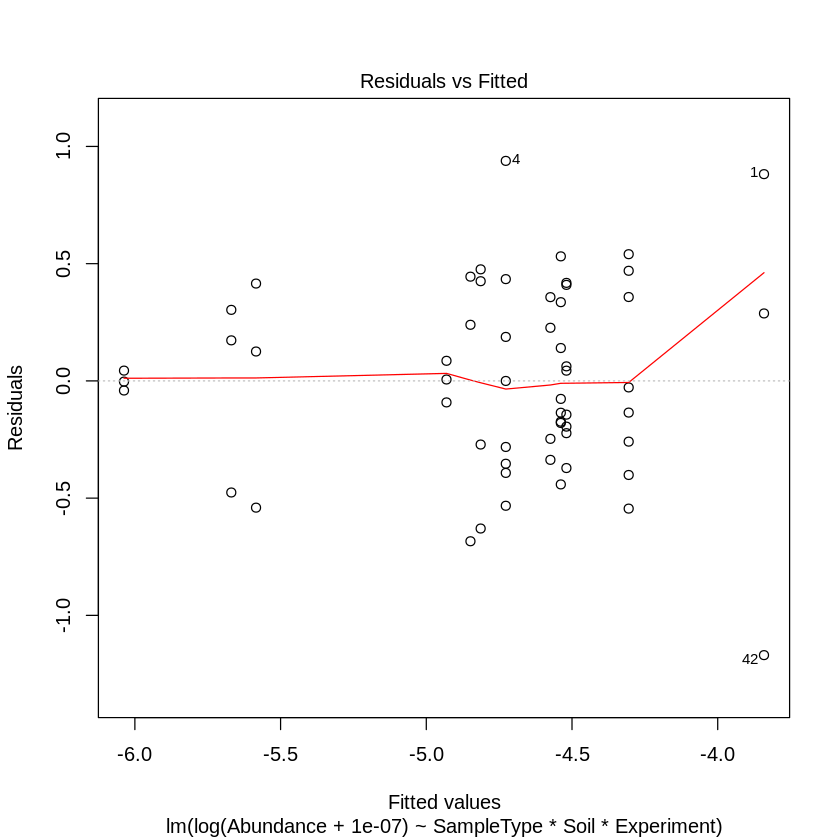

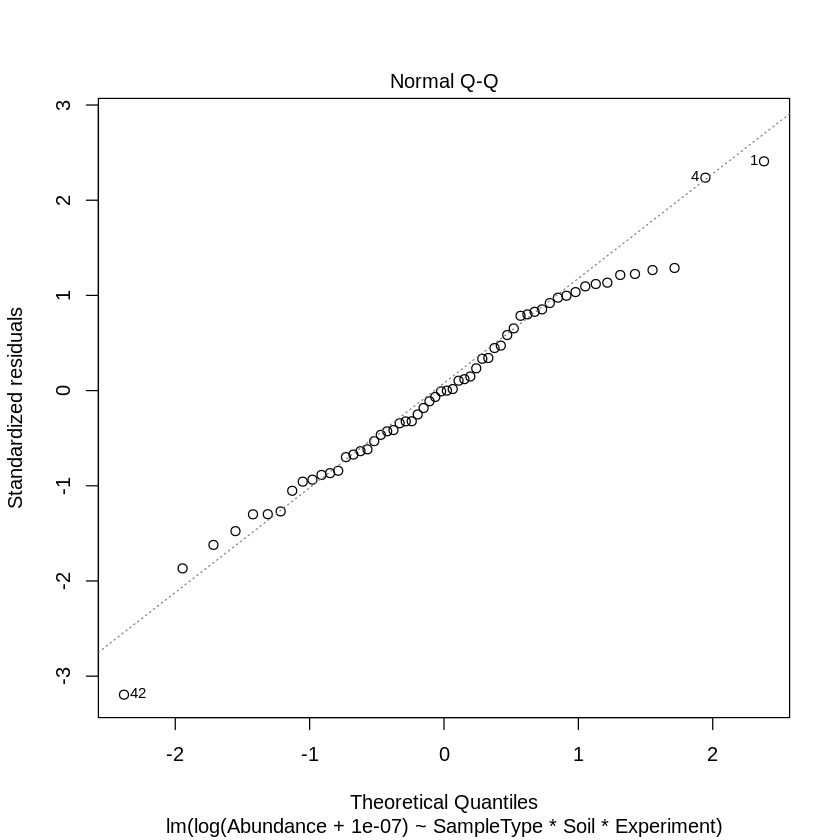

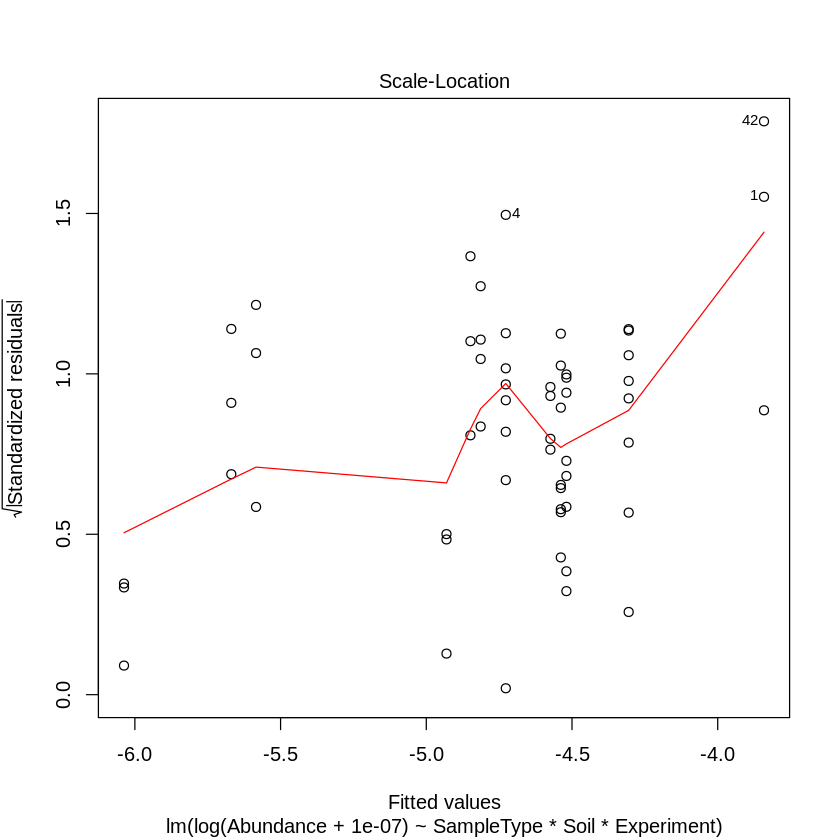

[1] "Chitinophagales"


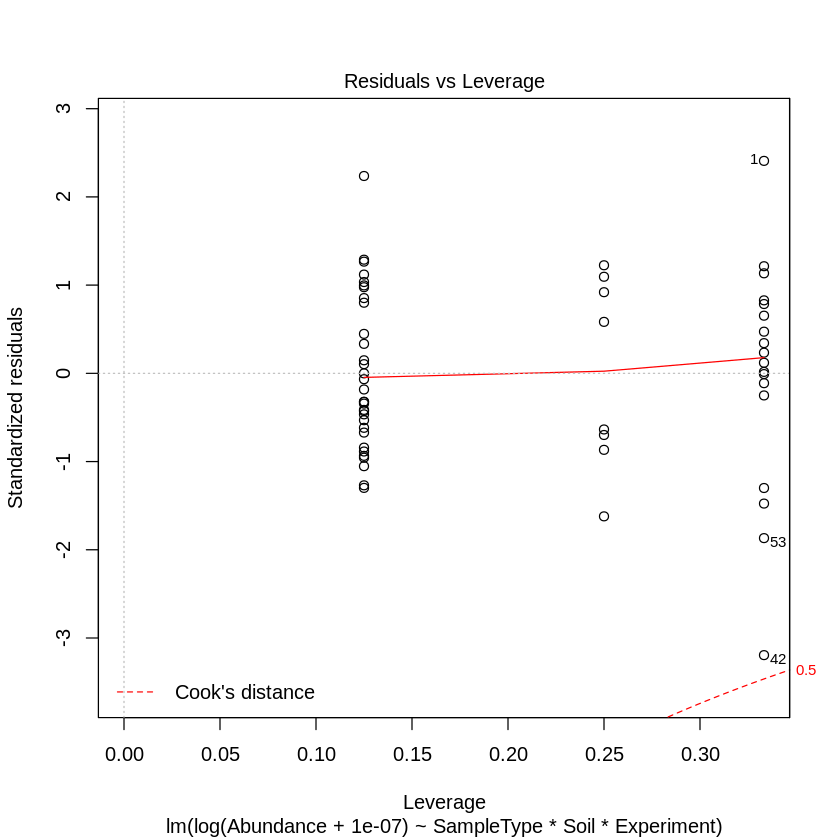

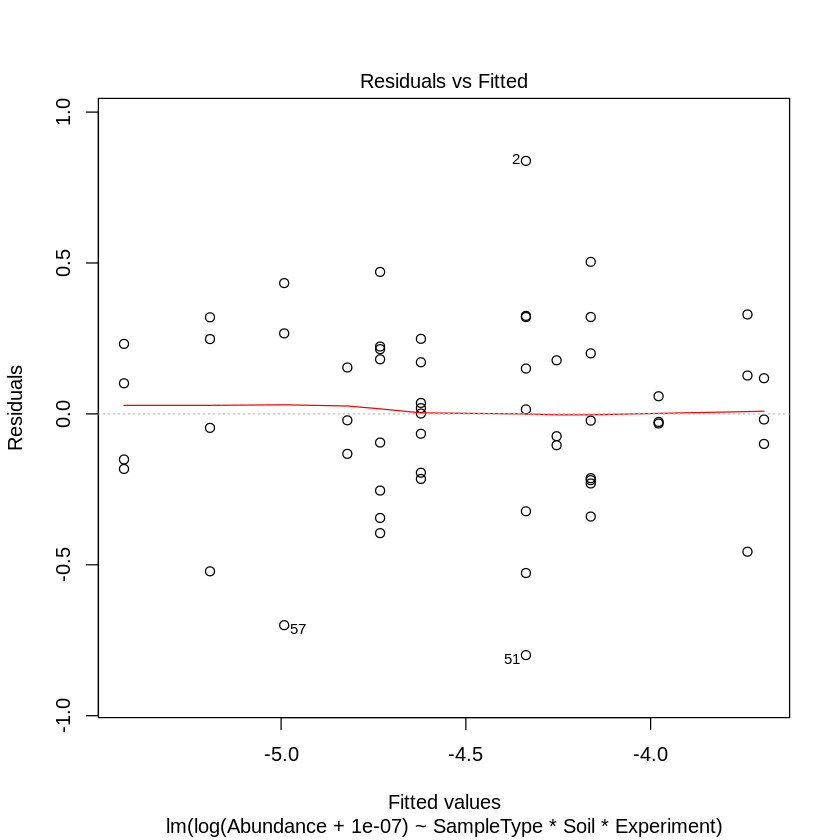

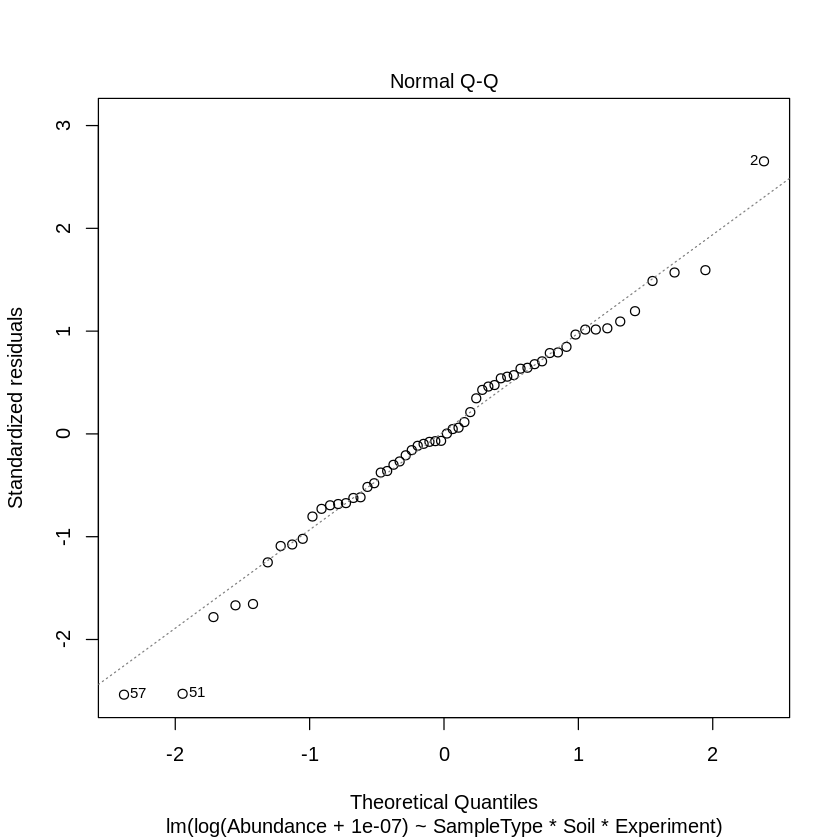

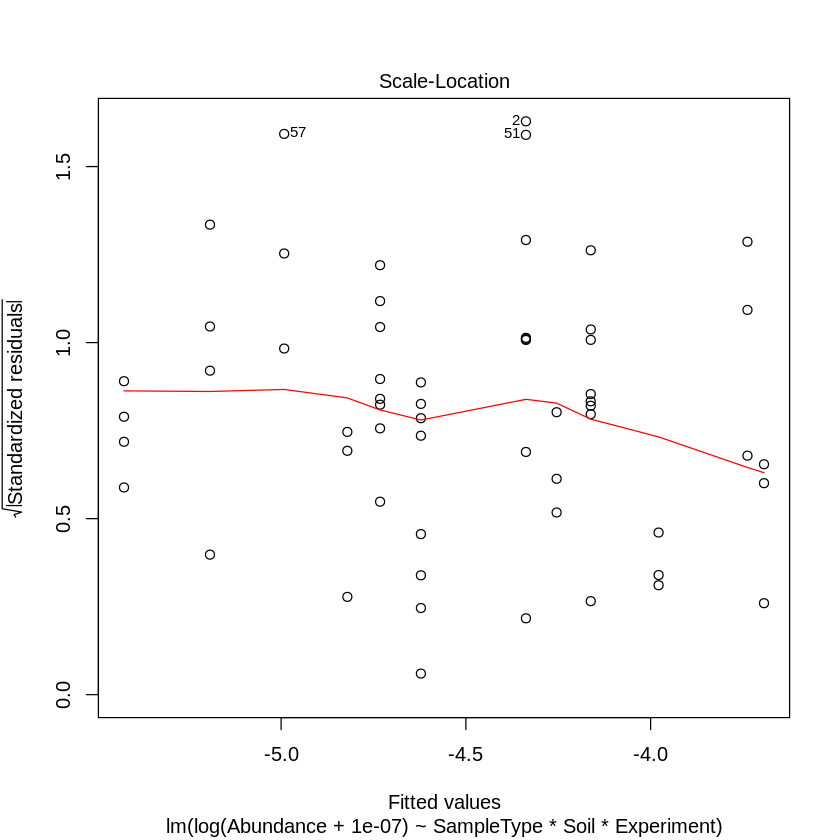

contrast,Soil,Experiment,estimate,SE,df,t.ratio,p.value,Order
CH - CS,Florence,1,0.7235365,0.2237533,46,3.233635,2.264256e-03,Betaproteobacteriales
CH - CS,Dryden,1,0.7981389,0.2237533,46,3.567048,8.565788e-04,Betaproteobacteriales
CH - CS,Pendelton,1,0.8806685,0.2237533,46,3.935890,2.783373e-04,Betaproteobacteriales
CH - CS,Florence,2,0.3623881,0.1370204,46,2.644775,1.114601e-02,Betaproteobacteriales
CH - CS,Dryden,2,1.0356251,0.1370204,46,7.558184,1.334755e-09,Betaproteobacteriales
CH - CS,Pendelton,2,0.5496504,0.1937761,46,2.836524,6.759663e-03,Betaproteobacteriales


contrast,Soil,Experiment,estimate,SE,df,t.ratio,p.value,Order,padj
CH - CS,Florence,1,0.72353651,0.2237533,46,3.2336346,2.264256e-03,Betaproteobacteriales,5.507651e-03
CH - CS,Dryden,1,0.79813890,0.2237533,46,3.5670482,8.565788e-04,Betaproteobacteriales,2.202631e-03
CH - CS,Pendelton,1,0.88066847,0.2237533,46,3.9358899,2.783373e-04,Betaproteobacteriales,8.638054e-04
CH - CS,Florence,2,0.36238810,0.1370204,46,2.6447754,1.114601e-02,Betaproteobacteriales,1.857668e-02
CH - CS,Dryden,2,1.03562515,0.1370204,46,7.5581838,1.334755e-09,Betaproteobacteriales,5.578714e-08
CH - CS,Pendelton,2,0.54965041,0.1937761,46,2.8365237,6.759663e-03,Betaproteobacteriales,1.267437e-02
CH - CS,Florence,1,-0.11483790,0.1524907,46,-0.7530813,4.552382e-01,Rhizobiales,4.877552e-01
CH - CS,Dryden,1,-0.30481954,0.1524907,46,-1.9989386,5.154369e-02,Rhizobiales,7.482148e-02
CH - CS,Pendelton,1,-0.07639753,0.1524907,46,-0.5009980,6.187616e-01,Rhizobiales,6.400982e-01
CH - CS,Florence,2,0.02016258,0.0933811,46,0.2159171,8.300070e-01,Rhizobiales,8.300070e-01


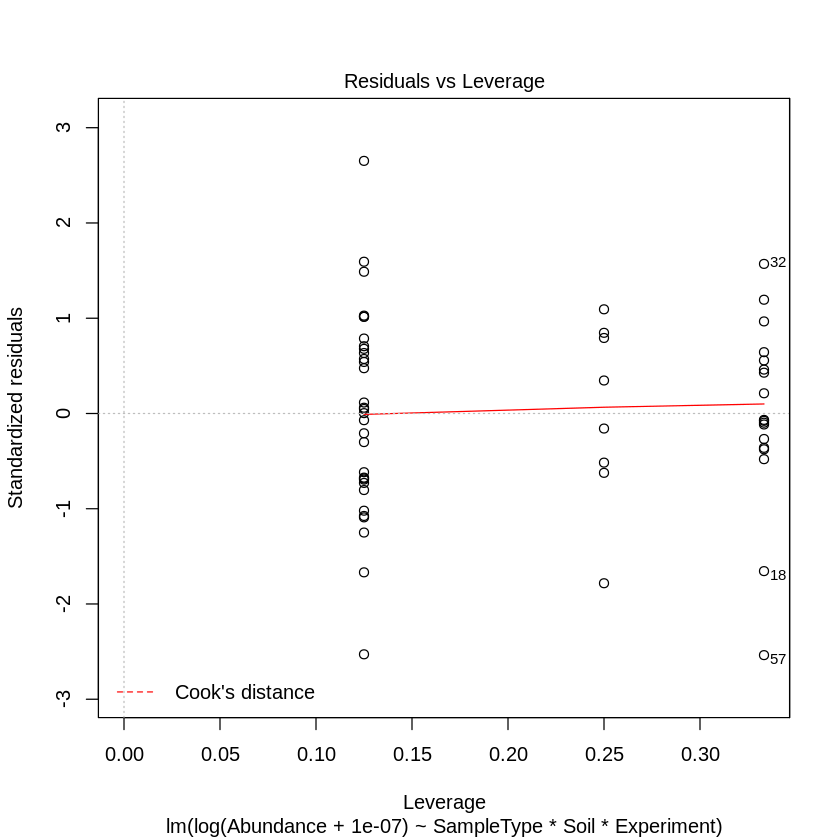

In [128]:
library(emmeans)
top15 = names(sort(taxa_sums(ps.order), decreasing = TRUE)[1:15])
tmp = prune_taxa(top15, ps.order) %>% subset_samples(Soil != "Sand" & Fungus == "Gv" & Experiment %in% c(1,2) & SampleType %in% c("CH", "CS")) %>% psmelt()

contrast.df = NULL
for (i in top15) {
    Mtmp = tmp %>% filter(OTU == i)
    OrderText = Mtmp$Order %>% unique() %>% as.character() 
    OrderText %>% print()
    m1 = lm(log(Abundance + 0.0000001)~SampleType*Soil*Experiment, data = Mtmp)
    plot(m1)
    emm1 = emmeans(m1, specs = pairwise ~ SampleType|Soil|Experiment, adjust = 'none') 
    
    r = emm1$contrasts %>% summary()
    r$Order = paste(OrderText)
    
    contrast.df = rbind(contrast.df, r)
    }
head(contrast.df)

contrast.df$padj = p.adjust(contrast.df$p.value, method = "BH")
contrast.df

## Make horizontal graph and organize by Dryden abundance

In [178]:
#Use same colors as ordination 
cs = brewer.pal(3,"Dark2")[2:3]

tmp = prune_taxa(top15, ps.order)

tmp = tmp %>%
    psmelt %>%
    mutate(Order = factor(Order, levels = rev(levels(Order))),
                         Experiment = factor(Experiment, levels = c(2,1))) %>%
    filter(Experiment %in% c(1,2) & SampleType %in% c("CH", "CS") & Fungus == "Gv" & Soil != "Sand") %>%
    group_by(SampleType, Soil, Order,Experiment) %>%
    summarize(mAbundance = mean(Abundance),
             sdAbundance = sd(Abundance),
             seAbundance = sdAbundance/sqrt(length(Abundance))) 
    
OrderLevel = tmp %>% 
    filter(SampleType == "CH" & Soil == "Dryden") %>%
    summarize(meanAbund = mean(mAbundance)) %>% 
    arrange(desc(meanAbund)) %>%
    .$Order %>%
    as.character()

OrderLevel
tmp = tmp %>% mutate(Order = factor(Order, levels = OrderLevel),
                    Soil = factor(Soil, levels = c("Dryden", "Florence", "Pendelton")))


levels(tmp$Order)
#head(OrderLevel)
  

Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'SampleType', 'Soil', 'Order' (override with `.groups` argument)
`summarise()` regrouping output by 'SampleType', 'Soil' (override with `.groups` argument)


[1] "Betaproteobacteriales" "Myxococcales"          "Rhizobiales"          
 [4] "Fibrobacterales"       NA                      "Cytophagales"         
 [7] "Gaiellales"            "Nitrososphaerales"     "Micrococcales"        
[10] "Chthoniobacterales"    "Sphingomonadales"      "Chitinophagales"      
[13] "Gemmatimonadales"      "Xanthomonadales"       "Caulobacterales"

[1] "Betaproteobacteriales" "Myxococcales"          "Rhizobiales"          
 [4] "Fibrobacterales"       "Cytophagales"          "Gaiellales"           
 [7] "Nitrososphaerales"     "Micrococcales"         "Chthoniobacterales"   
[10] "Sphingomonadales"      "Chitinophagales"       "Gemmatimonadales"     
[13] "Xanthomonadales"       "Caulobacterales"

In [179]:
head(tmp)
#subset to just the core hyphae samples for the join
CHtmp = filter(tmp, SampleType == "CH")
CStmp = filter(tmp, SampleType == "CS")
# join with the contrast data
# make the experiment a factor to allow joining as above
contrast.df = contrast.df %>% mutate(Experiment = factor(Experiment, levels = c(2,1)))

tmp.c = left_join(CHtmp, contrast.df)

#add CS samples back to dataset
tmp.f = bind_rows(tmp.c, CStmp)
head(tmp.f)
tail(tmp.f)

#reset levels based on Dryden soil and use ifelse statement to plot 
tmp.f = tmp.f %>% mutate(Order = factor(Order, levels = OrderLevel),
                    Soil = factor(Soil, levels = c("Dryden", "Florence", "Pendelton")),
                        sig = ifelse(padj < 0.05, '*', NA))



SampleType,Soil,Order,Experiment,mAbundance,sdAbundance,seAbundance
CH,Florence,Xanthomonadales,2,0.01452951,0.005959847,0.002107124
CH,Florence,Xanthomonadales,1,0.02904903,0.022598023,0.013046974
CH,Florence,Sphingomonadales,2,0.01360142,0.005379106,0.001901801
CH,Florence,Sphingomonadales,1,0.02315572,0.004727042,0.002729159
CH,Florence,Rhizobiales,2,0.07542546,0.018878269,0.006674476
CH,Florence,Rhizobiales,1,0.09596774,0.010139773,0.005854201


Joining, by = c("Soil", "Order", "Experiment")


SampleType,Soil,Order,Experiment,mAbundance,sdAbundance,seAbundance,contrast,estimate,SE,df,t.ratio,p.value,padj
CH,Florence,Xanthomonadales,2,0.01452951,0.005959847,0.002107124,CH - CS,0.23289423,0.2242328,46,1.0386269,3.044071e-01,3.467929e-01
CH,Florence,Xanthomonadales,1,0.02904903,0.022598023,0.013046974,CH - CS,1.82796703,0.3661707,46,4.9921177,9.025925e-06,4.828329e-05
CH,Florence,Sphingomonadales,2,0.01360142,0.005379106,0.001901801,CH - CS,-0.66035835,0.1521699,46,-4.3396124,7.744388e-05,3.030413e-04
CH,Florence,Sphingomonadales,1,0.02315572,0.004727042,0.002729159,CH - CS,-0.76125578,0.2484924,46,-3.0634973,3.650786e-03,7.467516e-03
CH,Florence,Rhizobiales,2,0.07542546,0.018878269,0.006674476,CH - CS,0.02016258,0.0933811,46,0.2159171,8.300070e-01,8.300070e-01
CH,Florence,Rhizobiales,1,0.09596774,0.010139773,0.005854201,CH - CS,-0.11483790,0.1524907,46,-0.7530813,4.552382e-01,4.877552e-01


SampleType,Soil,Order,Experiment,mAbundance,sdAbundance,seAbundance,contrast,estimate,SE,df,t.ratio,p.value,padj
CS,Pendelton,Caulobacterales,2,0.011875990,0.005327806,0.002663903,NA,NA,NA,NA,NA,NA,NA
CS,Pendelton,Caulobacterales,1,0.009391886,0.004340079,0.002505746,NA,NA,NA,NA,NA,NA,NA
CS,Pendelton,Betaproteobacteriales,2,0.069011149,0.017689892,0.008844946,NA,NA,NA,NA,NA,NA,NA
CS,Pendelton,Betaproteobacteriales,1,0.047666318,0.010750750,0.006206948,NA,NA,NA,NA,NA,NA,NA
CS,Pendelton,NA,2,0.046755207,0.007619398,0.003809699,NA,NA,NA,NA,NA,NA,NA
CS,Pendelton,NA,1,0.053687405,0.001797068,0.001037538,NA,NA,NA,NA,NA,NA,NA


Warning message:
“Removed 126 rows containing missing values (geom_text).”

Warning message:
“Removed 126 rows containing missing values (geom_text).”

png 
  2

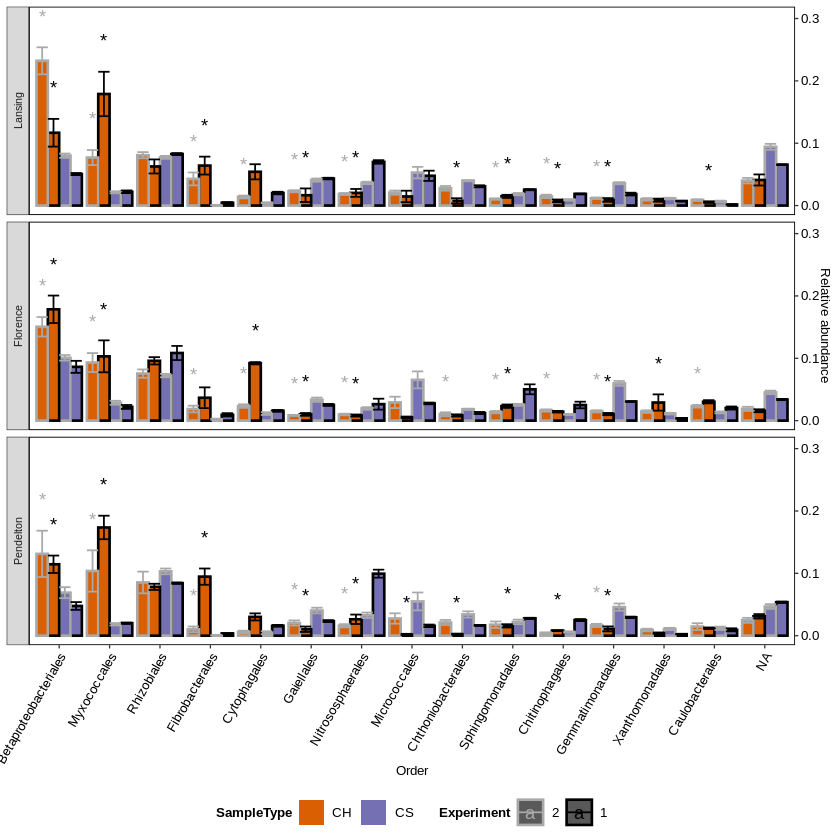

In [180]:
 # ggplot code, to group bars by experiment rather than sample type, switch position of fill and colour in aes
 p =   ggplot(tmp.f, aes(x = Order, y = mAbundance, fill = SampleType, colour = Experiment))+
            geom_bar(stat = 'identity', position = position_dodge(), size = .75)+
            theme_pub() +
            theme(legend.position = 'bottom', axis.text.x = element_text(angle = 60, hjust =1))+
            ylab("Relative abundance")+
            geom_errorbar(aes(ymin = mAbundance - seAbundance, 
                              ymax = mAbundance + seAbundance), position = position_dodge(), lty = 1)+
            geom_text(aes(y = mAbundance + seAbundance + 0.05, label=sig),  position = position_dodge(width = .9))+
            
            #scale_x_discrete(limits = rev(levels("Test")))+
            #coord_flip() +
           # scale_linetype_manual(values = c(2,1))+
            scale_fill_manual(values = cs) + #c("DarkRed", "Black"))+
            scale_color_manual(values=c('Dark Gray','Black'))+
            facet_grid(Soil~., switch = 'y')+
            scale_y_continuous(position = "right")
            
            
p

outfile = file.path(figDir,"OrderPlot_horizontal.pdf")
pdf(outfile, width = 7.086, height = 4, useDingbats = FALSE)
p
dev.off()

In [12]:
# #Use same colors as ordination 
# cs = brewer.pal(3,"Dark2")[2:3]
# ## Transform to relative abundance
# #ps.phylum = transform_sample_counts(ps.phylum, function(x) x / sum(x) )
# top20 = names(sort(taxa_sums(ps.order), decreasing = TRUE)[1:20])
# tmp = prune_taxa(top20, ps.order)

# tmp = tmp %>%
#     psmelt %>%
#     mutate(Order = factor(Order, levels = rev(levels(Order))),
#                          Experiment = factor(Experiment, levels = c(2,1))) %>%
#     filter(Experiment %in% c(1,2) & SampleType %in% c("CH", "CS") & Fungus == "Gv" & Soil != "Sand") %>%
#     group_by(SampleType, Soil, Order,Experiment) %>%
#     summarize(mAbundance = mean(Abundance),
#              sdAbundance = sd(Abundance),
#               seAbundance = sdAbundance/sqrt(length(Abundance)))

# OrderLevel = tmp %>% 
#     filter(SampleType == "CH" & Soil == "Dryden") %>%
#     summarize(meanAbund = mean(mAbundance)) %>% 
#     arrange(desc(meanAbund)) %>%
#     .$Order %>%
#     as.character()

# tmp = tmp %>% mutate(Order = factor(Order, levels = rev(OrderLevel)),
#                     Soil = factor(Soil, levels = c("Dryden", "Florence", "Pendelton")))

#    # ggplot code, to group bars by experiment rather than sample type, switch position of fill and colour in aes
#   p =   ggplot(tmp, aes(x = Order, y = mAbundance, fill = SampleType, colour = Experiment, alpha = Experiment))+
#             geom_bar(stat = 'identity', position = position_dodge())+
#             scale_alpha_discrete(breaks = c(1,2), range = c(.6,1))+
#             theme_pub() +
#             theme(legend.position = 'bottom', axis.title.x = element_blank())+
#             ylab("Relative abundance")+
#             scale_x_discrete(limits = rev(levels("Test")))+
#             coord_flip() +
#              geom_errorbar(aes(ymin = mAbundance - seAbundance, 
#                               ymax = mAbundance + seAbundance), position = position_dodge())+
#             scale_fill_manual(values = cs) + #c("DarkRed", "Black"))+
#             scale_color_manual(values=c('LightGray','Black'))+
#             facet_wrap(~Soil, ncol = 4)
            

       
           
        
           


# pdf(file = file.path(figDir,"Exp1-2_TaxonomicShiftbyOrder.pdf"), useDingbats = FALSE, width = 7.31, height = 8.5)
# p
# dev.off()



Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'SampleType', 'Soil', 'Order' (override with `.groups` argument)
`summarise()` regrouping output by 'SampleType', 'Soil' (override with `.groups` argument)
Warning message:
“Using alpha for a discrete variable is not advised.”

png 
  2

# Make graph including root compartment

In [189]:
cs

[1] "#D95F02" "#7570B3" "#1B9E77" "#D95F02"

In [203]:
#Use same colors as ordination 
cs = c('#d95f02', #CH, 
       '#7570b3', #CS,
       "#e6ab02", #RH
       "#a6761d") #RS

tmp = prune_taxa(top15, ps.order)

tmp = tmp %>%
    psmelt %>%
    filter(Experiment == '2' & SampleType %in% c("CH", "CS", "RH", "RS") & Fungus == "Gv" & Soil != "Sand") %>%
     group_by(Order, SampleType, Soil) %>%
    summarise(mAbundance = mean(Abundance),
              sdAbundance = sd(Abundance),
              seAbundance = sdAbundance/sqrt(length(Abundance))) 

OrderLevel = tmp %>% 
    filter(SampleType == "CH" & Soil == "Dryden") %>%
    summarize(meanAbund = mean(mAbundance)) %>% 
    arrange(desc(meanAbund)) %>%
    .$Order %>%
    as.character()

tmp = tmp %>% mutate(Order = factor(Order, levels = OrderLevel),
                    Soil = factor(Soil, levels = c("Dryden", "Florence", "Pendelton")),
                    #SampleType = factor(SampleType, levels = c("CH", "RH", "CS", "RS")),
                    Compartment = ifelse(SampleType %in% c("CS", "CH"), "Core", "Root Compartment"))


Warning message in psmelt(.):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”`summarise()` regrouping output by 'Order', 'SampleType' (override with `.groups` argument)
`summarise()` regrouping output by 'Order' (override with `.groups` argument)


In [185]:
OrderLevel

[1] "Betaproteobacteriales" "Rhizobiales"           "Myxococcales"         
 [4] "Fibrobacterales"       NA                      "Chthoniobacterales"   
 [7] "Gaiellales"            "Micrococcales"         "Nitrososphaerales"    
[10] "Chitinophagales"       "Cytophagales"          "Gemmatimonadales"     
[13] "Sphingomonadales"      "Xanthomonadales"       "Caulobacterales"

png 
  2

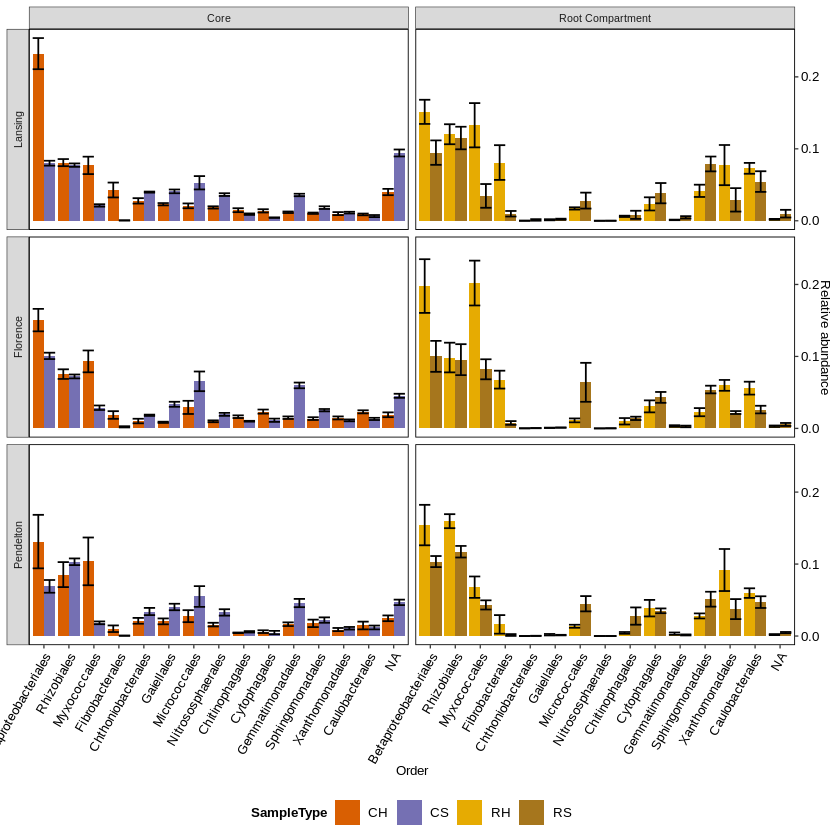

In [208]:
p =   ggplot(tmp, aes(x = Order, y = mAbundance, fill = SampleType))+
            geom_bar(stat = 'identity', position = position_dodge(), size = .75)+
            theme_pub() +
            theme(legend.position = 'bottom', axis.text.x = element_text(angle = 60, hjust =1))+
            ylab("Relative abundance")+
            geom_errorbar(aes(ymin = mAbundance - seAbundance, 
                              ymax = mAbundance + seAbundance), position = position_dodge(), lty = 1)+
           
            
            #scale_x_discrete(limits = rev(levels("Test")))+
            #coord_flip() +
           # scale_linetype_manual(values = c(2,1))+
            scale_fill_manual(values = cs) + #c("DarkRed", "Black"))+
            scale_color_manual(values=c('Dark Gray','Black'))+
            facet_grid(Soil~Compartment, switch = 'y')+
            scale_y_continuous(position = "right")
            
            
p

outfile = file.path(figDir,"OrderPlot_wRootCompartment_horizontal.pdf")
pdf(outfile, width = 7.086, height = 6.5, useDingbats = FALSE)
p
dev.off()